In [ ]:
%pip install azure-ai-ml
%pip install azureml-rag[cognitive_search,data_generation]==0.2.25
%pip install openai==1.9.0

In [ ]:
# If `import win32file` fails with a DLL error then run the following and restart kernel:
# %pip uninstall -y pywin32
# %conda install -y --force-reinstall pywin32

# Create a FAISS based Vector Index for DBCopilot with AzureML
We'll walk through setting up an AzureML Pipeline which grounding a DataBase into a LangChain-compatible FAISS Vector Index and create the endpoint and the promptflow to consume this index to serve as a DBCopilot chatbot.

## Get a client for AzureML Workspace

`Azure Machine Learning Workspace` provides a centralized place to work with all the artifacts you create when you use Azure Machine Learning. The workspace keeps a history of all training runs, including logs, metrics, output, and a snapshot of your scripts. It is tied to an Azure subscription and resource group, and has an associated SKU.

To use `Azure Machine Learning Workspace`, you need to have an Azure subscription. You can create a workspace using the Azure portal, Azure CLI, or Azure Machine Learning SDK. Once created, you can use the workspace to experiment, train, and deploy machine learning models.

For more information on how to use `Azure Machine Learning Workspace`, you can visit the [Microsoft Learn](https://learn.microsoft.com/en-us/azure/machine-learning/concept-workspace?view=azureml-api-2) website. It provides detailed documentation on how to create and use the workspace, as well as examples and tutorials to help you get started.

This cells below will connect to the workspace in which the `FAISS based Vector Index for DBCopilot` job will be run.

Enter your Workspace details below, running this still will write a `workspace.json` file to the current folder.

In [ ]:
%%writefile workspace.json
{
    "subscription_id": "<subscription_id>",
    "resource_group": "<resource_group>",
    "workspace_name": "<workspace_name>"
}

### Create an instance of MLClient
`MLClient` is a client class in the `azure.ai.ml` Python package that enables interaction with Azure Machine Learning services. It provides a simple way to manage Azure ML resources such as workspaces, jobs, models, and more. You can use this client to create or update Azure ML resources asynchronously or synchronously.

MLClient is how you interact with AzureML.

For more information on how to use MLClient, you can visit the [Microsoft Learn](https://learn.microsoft.com/en-us/python/api/azure-ai-ml/azure.ai.ml.mlclient?view=azure-python) website. It provides detailed documentation on how to use the package.


In [ ]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient
from azureml.core import Workspace

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

try:
    ml_client = MLClient.from_config(credential=credential, path="workspace.json")
except Exception as ex:
    raise Exception(
        "Failed to create MLClient from config file. Please modify and then run the above cell with your AzureML Workspace details."
    ) from ex

ws = Workspace(
    subscription_id=ml_client.subscription_id,
    resource_group=ml_client.resource_group_name,
    workspace_name=ml_client.workspace_name,
)
print(ml_client)

## Create a Datastore

In Azure Machine Learning, a `datastore` is an entity that references an underlying storage or data source and contains the authentication and credentials to access the referenced store. It provides a common, easy-to-use API that interacts with different storage types such as Blob, Files, and ADLS.

Azure Machine Learning datastores are not required for accessing data in Azure storage accounts. However, they offer several benefits such as easier discovery of useful datastores in team operations and a centralized place to work with all the artifacts you create when you use Azure Machine Learning.

To create an Azure Machine Learning datastore, you need to have an Azure subscription and an Azure Machine Learning workspace. You can create a datastore using the Azure portal, Azure CLI, or Azure Machine Learning SDK. Once created, you can use the datastore to access data in your storage account.

For more information on how to create and use datastores in Azure Machine Learning, you can visit the [Microsoft Learn](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-datastore?view=azureml-api-2&tabs=sdk-identity-based-access%2Csdk-adls-identity-access%2Csdk-azfiles-accountkey%2Csdk-adlsgen1-identity-access%2Csdk-onelake-identity-access) website. It provides detailed documentation on how to create and use datastores, as well as examples and tutorials to help you get started.


1. Go to workspace in Azure Portal
2. Click **Data** -> **Datastore** -> **+ Create**
3. Fill in the datastore form


### SQL Server Datastore
| Field | Value |
| --- | --- |
| Datastore name | the name for the datastore |
| Datastore type | Azure SQL Database |
| Account information| could be found in the Azure SQL Database overview page |
| Authentication type | SQL Authentication/ Service principal |
| Authentication info | SQL Authentication: username and password; Service principal: tenant id, client id, client secret |
### Kusto / Cosmos / ClickHouse Datastore
| Field | Value |
| --- | --- |
| Datastore name | the name for the datastore |
| Datastore type | Custom(preview) |
| Custom Datastore type | could fill in the custom type |
| Credential value | Datastore credential, an optional field that can be updated later.<br>Value will be stored securely in Azure Key Vault |
| Properties |Add any additional properties required for this datastore |
##### Additional properties required by Kusto / Cosmos / ClickHouse
<table>
    <tr>
        <td></td> 
        <td colspan="2"><b>Kusto</b></td> 
        <td colspan="2"><b>ClickHouse</b></td> 
        <td colspan="2"><b>Cosmos</b></td> 
   </tr>
    <tr>
        <td rowspan="6"><b>Required</b> <br/><b>properties</b></td>     
         <td>Property</td> 
      	 <td>Value</td> 
         <td>Property</td> 
      	 <td>Value</td> 
         <td>Property</td> 
      	 <td>Value</td> 
    </tr>
    <tr>
        <td>connection</td> 
        <td>connect to external data sources for training</td>
        <td>host</td>
        <td>host name or IP address of the ClickHouse database server</td>
        <td>url</td>
        <td>url of Azure Cosmos DB services</td>      
    </tr>
    <tr>
        <td>connection_string</td> 
        <td>the string that contains the information needed to connect <br>to an external data source for training</td>
        <td>user</td>
        <td>user name used to authenticate the database user for the connection</td>
        <td>key</td>
        <td> access key used for authorizing access and operations to <br>an Azure Cosmos DB account</td>      
    </tr>
    <tr>
        <td>database</td> 
        <td>database name</td>
        <td>port</td>
        <td>The port on which the ClickHouse server listens. By default, ClickHouse <br>uses port number 8123 as the client connection port</td>
        <td>container</td>
        <td>logical unit used to organize and store documents</td>      
    </tr>
    <tr>
        <td>tenant_id</td> 
        <td>unique identifier for your Azure Active Directory tenant</td>
        <td>password</td>
        <td>secret string that the user uses to verify their identity</td>
        <td>database</td>
        <td>database name</td>      
    </tr>
    <tr>
        <td>client_id</td> 
        <td>the identifier for a managed identity that is used to retrieve <br>a credential for accessing resources within the code for a <br>submitted job</td>
        <td></td>
        <td></td>
        <td></td>
        <td></td>      
    </tr>
</table>

Use the datastore you created

In [ ]:
datastore_name = "<test_db_datastore_name>"
db_datastore_uri = f"azureml://datastores/{datastore_name}"

### Create a Data assets
1. Go to workspace in Azure Portal
2. Click **Data** -> **Data assets** -> **+ Create**
3. Fill in the Data assets form
#### SQLite/Sheet Data assets
| Field | Value |
| --- | --- |
| Data assets name | the name for the Data assets |
| Data assets type | File(uri_file) / Folder(uri_folder) |
| Data source | From a URI / From Azure storage / From local files |

Different data source, Different parameters

<table style="margin-left: 0; margin-right: auto;">
    <tr> 
        <td colspan="2"><b>From a URL</b></td> 
        <td colspan="2"><b>From Azure storage</b></td> 
        <td colspan="2"><b>From local</b></td> 
   </tr>
    <tr>     
         <td>Field</td> 
      	 <td>Value</td> 
         <td>Field</td> 
      	 <td>Value</td> 
         <td>Field</td> 
      	 <td>Value</td> 
    </tr>
    <tr>
        <td>URI</td>
        <td>path parameter that points to the data location. Three formats are supported: <br>1. A path on a public http(s) server <br>2. A path on Azure storage<br>3. A path on a datastore</td>
        <td>Source storage type</td>
        <td>Azure Blob Storage / Azure file share / Azure Data Lake Storage Gen1 /<br> Azure Data Lake Storage Gen2</td>
        <td>Destination storage type</td> 
        <td>Azure Blob Storage / Azure Data Lake Storage Gen2</td>     
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td>Storage path</td>
        <td>storage path you want to use for this data asset</td>
        <td>File selection</td>
        <td>Upload file</td>     
    </tr>

</table>


<H3>Example for Tabular Data</H3>

In [ ]:
%pip install pandas
%pip install -U mltable azureml-dataprep[pandas]

In [ ]:
%%writefile test.csv
id,text
0,Hello world!

In [ ]:
import sqlite3
import mltable
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

tbl = mltable.from_delimited_files([{"file": "test.csv"}])
# Convert tabular data to sqlite db
df = tbl.to_pandas_dataframe()
conn = sqlite3.connect("test.db")
df.to_sql("test_table", conn, if_exists="replace")
conn.close()
# Upload sqlite db to AzureML
my_data = Data(
    name="test_db",
    description="test db",
    version="1",
    path="test.db",
    type=AssetTypes.URI_FILE,
)
my_data = ml_client.data.create_or_update(my_data)
print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")
db_datastore_uri = my_data.path

## Azure OpenAI

### Deploy Completion Model and Embedding Model in the Azure OpenAI Service.

`Completion` models are machine learning models that generate text completions given a prompt. The model is trained on a large corpus of text data and can generate high-quality text outputs in response to a wide range of prompts.

OpenAI offers several text generation models, including GPT-3, GPT-4, and DALL-E. These models are capable of understanding natural language, code, and images, and can be used to build applications that draft documents, write computer code, answer questions, analyze texts, and more.

For more information on how to use OpenAI's text generation models, you can visit the [OpenAI Platform](https://medium.com/@bezbos/openai-completions-api-complete-guide-8da45b3d780b) website. It provides detailed documentation on how to use the package.

`Embedding` models are machine learning models that maps words or phrases to vectors of real numbers. The vectors are designed to capture the semantic meaning of the words or phrases, and can be used as input to other machine learning models.

OpenAI offers several text embedding models, including GPT-3, GPT-4, and DALL-E. These models are capable of understanding natural language, code, and images, and can be used to build applications that draft documents, write computer code, answer questions, analyze texts, and more.

For more information on how to use OpenAI's text embedding models, you can visit the [OpenAI Platform](https://medium.com/@bezbos/openai-completions-api-complete-guide-8da45b3d780b) website. It provides detailed documentation on how to use the package.

[Follow these instructions](https://learn.microsoft.com/en-us/azure/cognitive-services/openai/how-to/create-resource?pivots=web-portal) to setup an Azure OpenAI Instance and deploy the model. To deploy a model in Azure OpenAI service:

1. Go to Azure OpenAI service in the Azure Portal and click on Open AI Studio
2. In Azure OpenAI Studio, select Deployments under Management, and click "Create new deployment"

`gpt-35-turbo` is the recommended Completion model for quality results.

Once you have the models deployed in Azure OpenAI you can specify your `Completion` model name and `Embedding` model name, along with their respective deployment names.

### Create Azure OpenAI Connection
`Connections` in prompt flow play a crucial role in establishing connections to remote APIs or data sources. They encapsulate essential information such as endpoints and secrets, ensuring secure and reliable communication. In the Azure Machine Learning workspace, connections can be configured to be shared across the entire workspace or limited to the creator. Secrets associated with connections are securely persisted in the corresponding Azure Key Vault, adhering to robust security and compliance standards. Prompt flow provides various prebuilt connections, including Azure Open AI, Open AI, and Azure Content Safety. These prebuilt connections enable seamless integration with these resources within the built-in tools. Additionally, users have the flexibility to create custom connection types using key-value pairs, empowering them to tailor the connections to their specific requirements, particularly in Python tools.

To learn more about Connection, visit the [Microsoft Learn](https://learn.microsoft.com/en-us/azure/machine-learning/prompt-flow/concept-connections?view=azureml-api-2) website for detailed documentation on how to create and use the tool.

Once Connection has been created, enter the Connection name below. This Connection will be referenced in the succeeding steps for this accelerator.


In [ ]:
aoai_connection_name = "<azure_openai_connection>"

### Connect to Azure OpenAI Service
Connecting to Azure OpenAI service requires calling the `get_connection_by_name_v2` function in the Azure ML SDK (azureml.rag.utils.connections). The code below will also create a connection using the `create_connection_v2 function` if the connection does not exist.

The `aoai_connection_name` will need to be provided. This can be found in the `Azure Machine Learning Studio-> Prompt flow-> Connections`.

In [ ]:
from azureml.rag.utils.connections import (
    get_connection_by_name_v2,
    create_connection_v2,
)

try:
    aoai_connection = get_connection_by_name_v2(ws, aoai_connection_name)
except Exception as ex:
    # Create New Connection
    # Modify the details below to match the `Endpoint` and API key of your AOAI resource, these details can be found in Azure Portal
    raise RuntimeError(
        "Have you entered your AOAI resource details below? If so, delete me!"
    )
    aoai_connection = create_connection_v2(
        workspace=ws,
        name=aoai_connection,
        category="AzureOpenAI",
        # 'Endpoint' from Azure OpenAI resource overview
        target="https://<endpoint_name>.openai.azure.com/",
        auth_type="ApiKey",
        credentials={
            # Either `Key` from the `Keys and Endpoint` tab of your Azure OpenAI resource, will be stored in your Workspace associated Azure Key Vault.
            "key": "<api-key>"
        },
        metadata={"ApiType": "azure", "ApiVersion": "2023-05-15"},
    )

aoai_connection_id = aoai_connection["id"]
print(aoai_connection)
# print(aoai_connection_id)

Now that your Workspace has a connection to Azure OpenAI we will make sure the `gpt-35-turbo` model has been deployed ready for inference. This cell will fail if there is not deployment for the embedding model. It is recommended to deploy the `text-embedding-ada-002` embedding model, as it is currently the only one supported.

In [ ]:
# from azureml.rag.utils.deployment import infer_deployment

aoai_embedding_model_name = "text-embedding-ada-002"
try:
    aoai_embedding_deployment_name = "<your_aoai_embedding_deployment_name>"
    # aoai_embedding_deployment_name = infer_deployment(
    #     aoai_connection, aoai_embedding_model_name
    # )
    # print(
    #     f"Deployment name in AOAI workspace for model '{aoai_embedding_model_name}' is '{aoai_embedding_deployment_name}'"
    # )
except Exception as e:
    print(e)
    print(
        f"Deployment name in AOAI workspace for model '{aoai_embedding_model_name}' is not found."
    )
    print(
        f"Please create a deployment for this model by following the deploy instructions on the resource page for '{aoai_connection['properties']['target']}' in Azure Portal."
    )

In [ ]:
# from azureml.rag.utils.deployment import infer_deployment

aoai_completion_model_name = "gpt-35-turbo"
try:
    aoai_completion_deployment_name = "<your_aoai_completion_deployment_name>"
    # aoai_completion_deployment_name = infer_deployment(
    #     aoai_connection, aoai_completion_model_name
    # )
except Exception as e:
    print(
        f"Deployment name in AOAI workspace for model '{aoai_completion_model_name}' is not found."
    )
    print(
        f"Please create a deployment for this model by following the deploy instructions on the resource page for '{aoai_connection['properties']['target']}' in Azure Portal."
    )

print(
    f"Deployment name in AOAI workspace for model '{aoai_completion_model_name}' is '{aoai_completion_deployment_name}'"
)

Finally we will combine the deployment and model information into a uri form which the AzureML embeddings components expect as input.

In [ ]:
llm_completion_config = f'{{"type":"azure_open_ai","model_name":"{aoai_completion_model_name}","deployment_name":"{aoai_completion_deployment_name}","temperature":0,"max_tokens":"1500"}}'

## Option1：Use DBCopilot with MIR Endpoint

### Create Endpoint

#### Create a new Endpoint in AzureML by using the following code

In [ ]:
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
)

# Create the online endpoint
endpoint_name = "<my-test-endpoint>"
endpoint = ManagedOnlineEndpoint(
    name=endpoint_name, description="Test managed online endpoint"
)
ml_client.begin_create_or_update(endpoint)

#### Create a new Endpoint in AzureML by Azure AI Machine Learning Studio portal

##### Create an Azure ML Model
In Azure Machine Learning, a `model` is the result of a machine learning training run or some other model training process outside of Azure. It represents the output of a machine learning algorithm that has been trained on a dataset to make predictions or decisions. A model can be registered in an Azure Machine Learning workspace, where it is represented by a name and a version. Once registered, a model can be used to create a Docker image and deploy it as a real-time endpoint that can be used for inference requests.

To create a model:

1. In Azure ML Studio, go to "Models"
2. Click "Register"

To learn more visit the [Microsoft Learn](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-manage-models?view=azureml-api-2&tabs=cli%2Cuse-local) website for detailed documentation on how to use Azure ML models.

> **Note:** Why create a model? In Azure Machine Learning (AML), the purpose of creating an endpoint is to deploy one or more models as a web service. Therefore, when creating an endpoint, you need to select at least one registered model. This model will be loaded into the endpoint and used to process requests from clients. If you try to create an endpoint without selecting a model, AML will not know which model to load to process requests, and this will cause an error. Therefore, you must select one or more models when creating an endpoint. However, DBCopilot does not need to use or involve a model. The primary reason we create a model is because creating an endpoint requires a model for it to be successfully created.




In [ ]:
from azureml.core import Model

model = Model.register(
    model_path="<model.pkl>",
    model_name="<my_model>",
    tags={"area": "diabetes", "type": "regression"},
    description="Ridge regression model to predict diabetes",
    workspace=ws,
)

##### Create a Endpoint to Invoke the Azure ML Model

1. **Go to the Workspace**: Log in to the Azure Portal and navigate to your Azure Machine Learning workspace. <br>
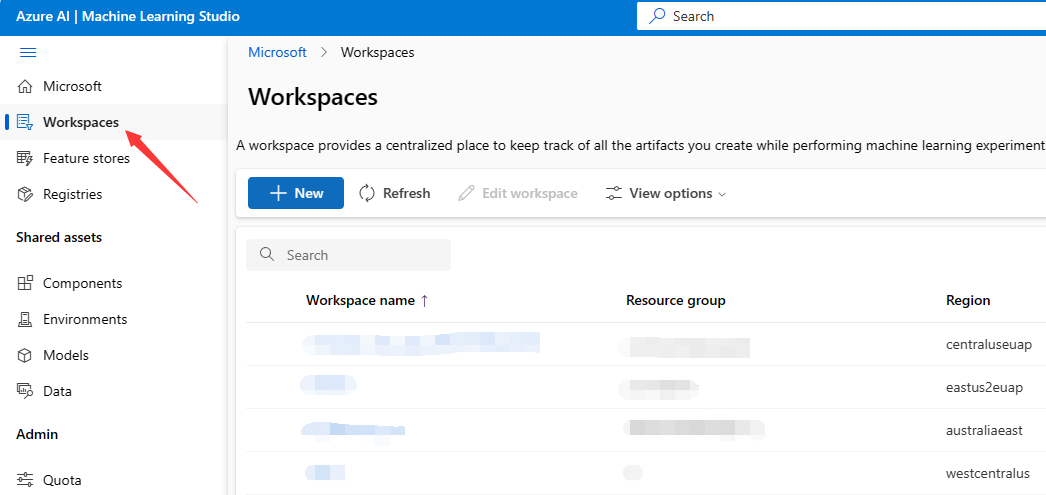
2. **Access Endpoints**: In the left-hand menu, find and click on "Endpoints".<br> 
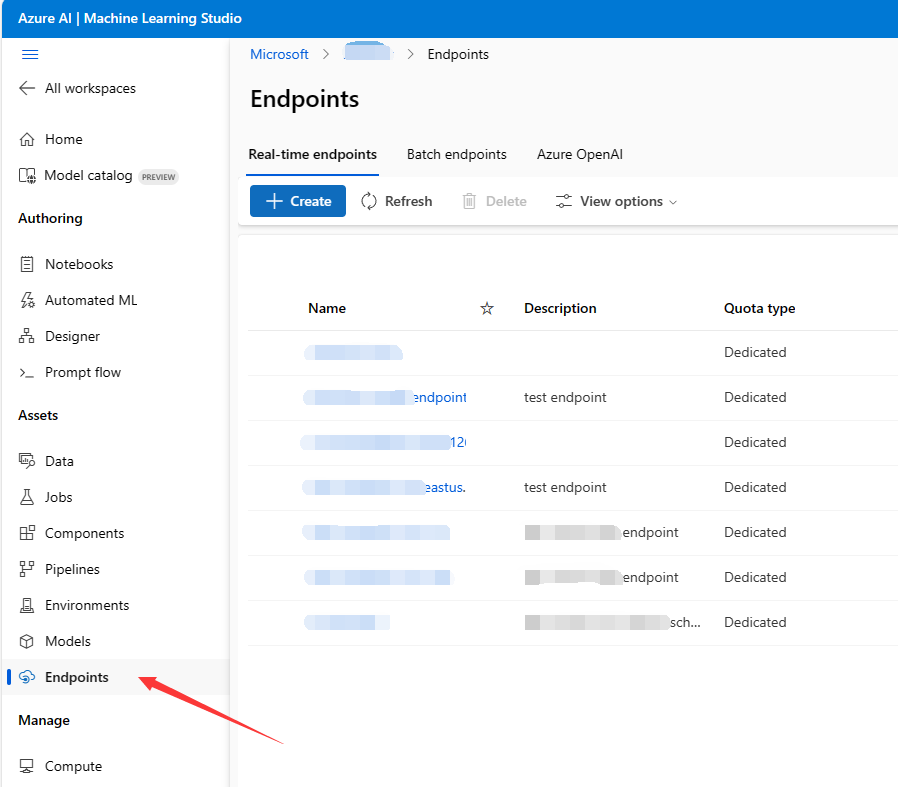
3. **Create Real-time Endpoint**: In the Endpoints page, click on "Real-time endpoints", then click on "+ Create".<br> 
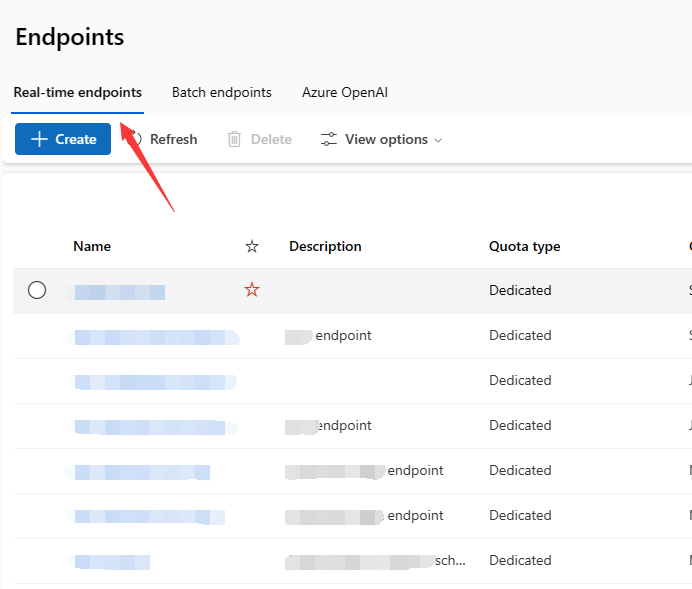
4. **Select a Model**: In the create endpoint form, you need to select a registered model. If you have not registered a model yet, you will need to do this in the "Models" page first.(<b>the model is not important you can choose any one. When registering a model, you can upload an empty file as the model.</b>)<br>
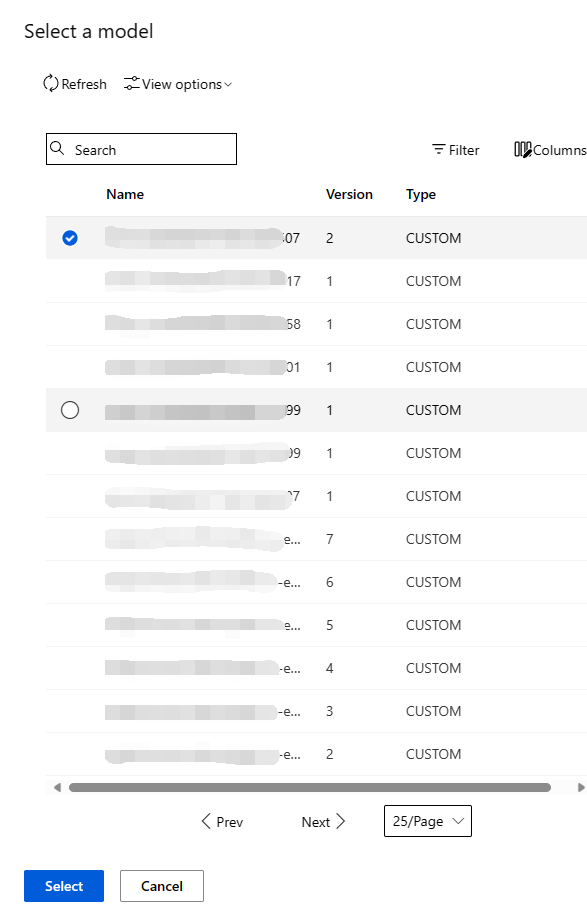
5. **Fill in the Endpoint Form**: In the form, you need to provide the following information:
   1. **Select Endpoint**: An endpoint is used to deploy and score your models. From the Azure Portal, navigate to your Azure Machine Learning workspace and select "Endpoints" from the sidebar.

   2. **Endpoint Details**:
      - **Endpoint Name**: Provide a unique identifier for your endpoint.
      - **Description**: Write a brief note about the endpoint's purpose.
      - **Compute Type**: Select the type of compute the endpoint will run on.
      - **Authentication Type**: Choose the type of authentication for the endpoint (Key-based or Token-based).
      - **Endpoint Tags**: Add tags to your endpoint for better organization and identification of your resources.<br>
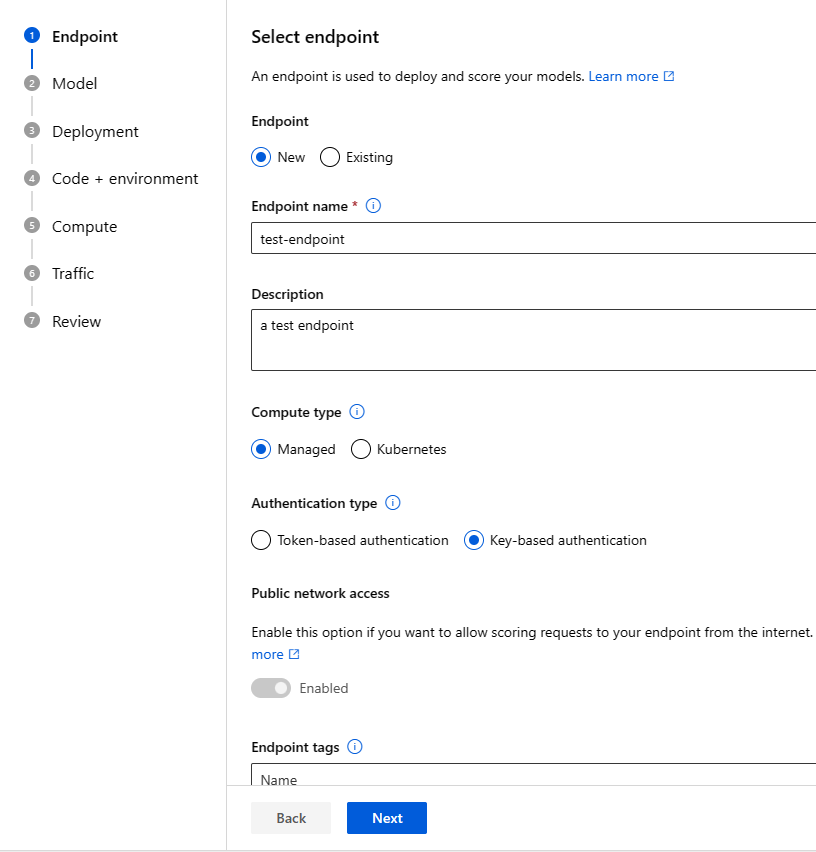
   3. **Deployment**:
      - **Deployment Name**: Provide a name for your deployment.
      - **Scoring Timeout (seconds)**: Specify the timeout for scoring in seconds.<br>
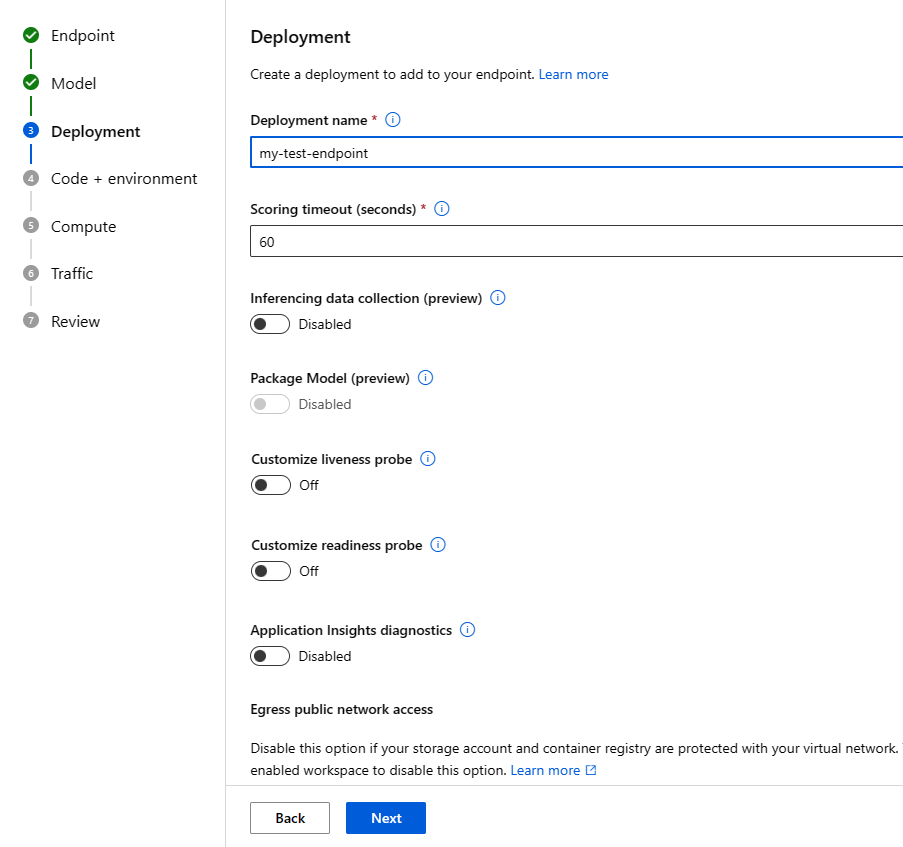
   4. **Code and Environment for Inferencing**: For the selected model, you need to provide at least one scoring Python script and an environment. 
      - **Select a Scoring Script for Inferencing**: Choose the Python script that will be used for scoring.(Here, you can put an empty file.)
      - **Optional Script(s)**: If you have any additional scripts, add them here.
      - **Select an Environment for Inferencing**: Choose the environment that will be used for scoring.<br>
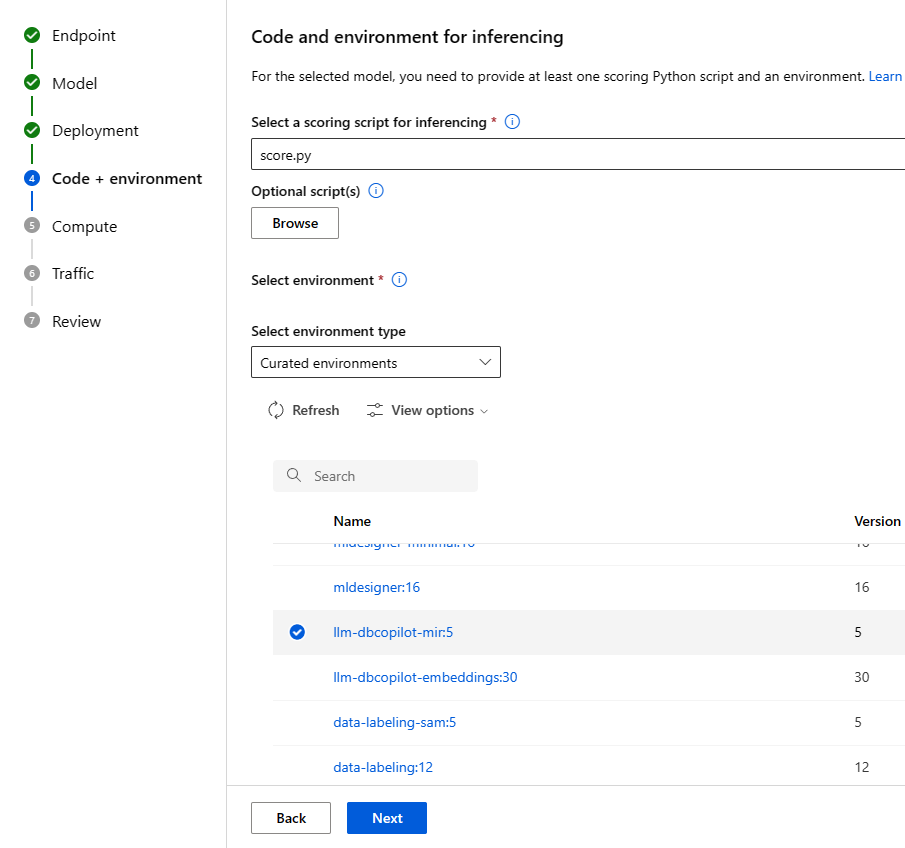
   5. **Compute**
      - **Virtual Machine**: Select the type of virtual machine. For example, "Standard_DS3_v2" which includes 4 Cores, 14 GB RAM, 28 GB Disk, and costs \$0.29/hr.
      - **Instance Count**: Specify the number of instances for your deployment.<br> 
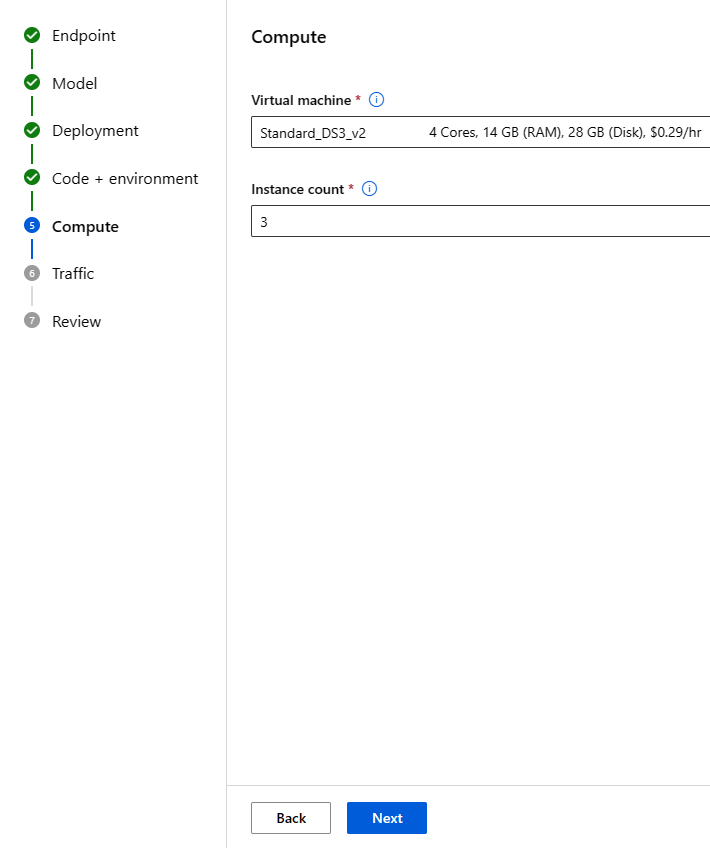
   6. **Live Traffic**: Ensure that the allocated live traffic between all deployments adds up to either 0% or 100%.<br>
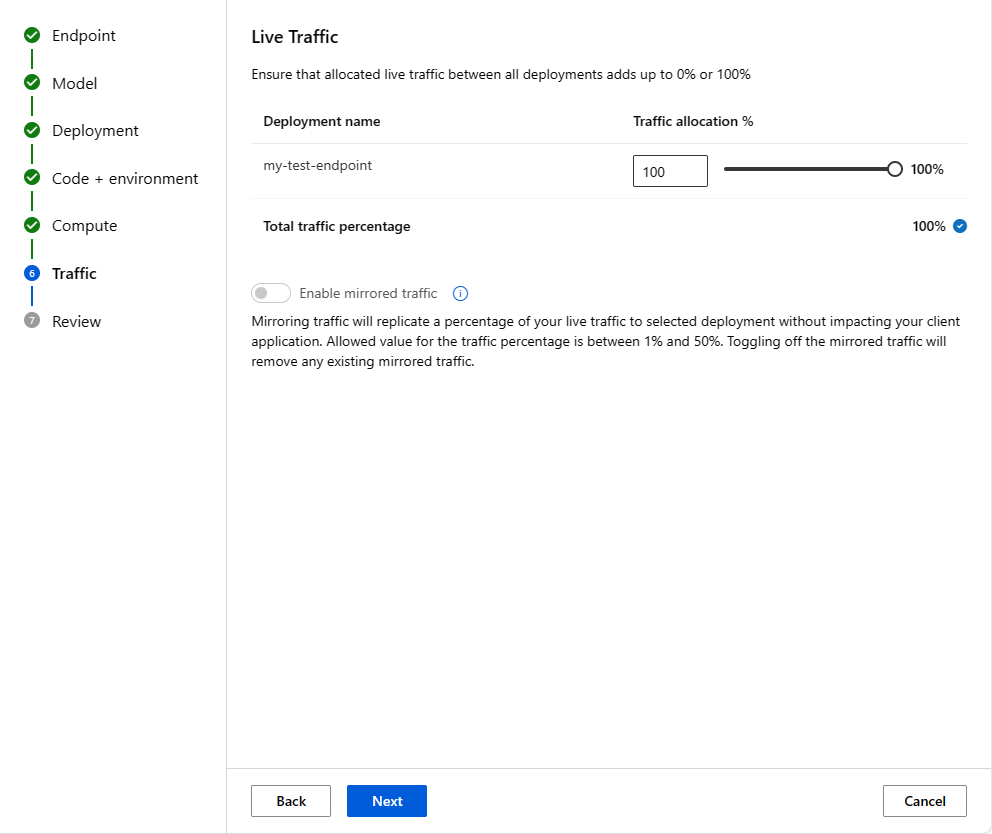

After filling in all the necessary information, click on the "Create" button. Azure ML will begin creating your endpoint, and you can monitor the progress on the Endpoints page.


### Set Endpoint Authentication



Add auzreml online endpoint’s identity with azureml workspace’s `AzureML Data Scientist` role. Use the azureml online endpoint’s name to search for the identity.

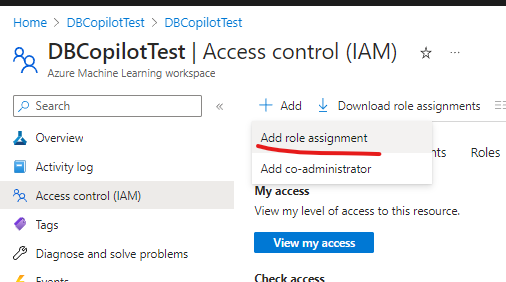

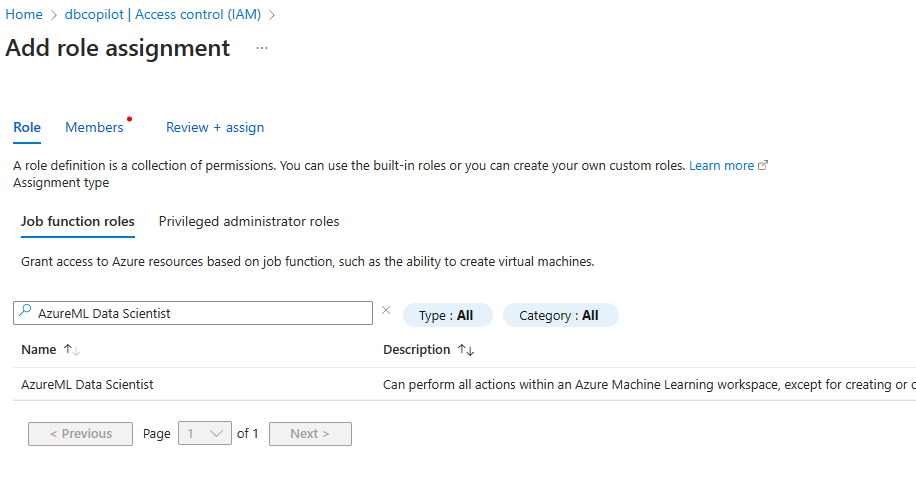

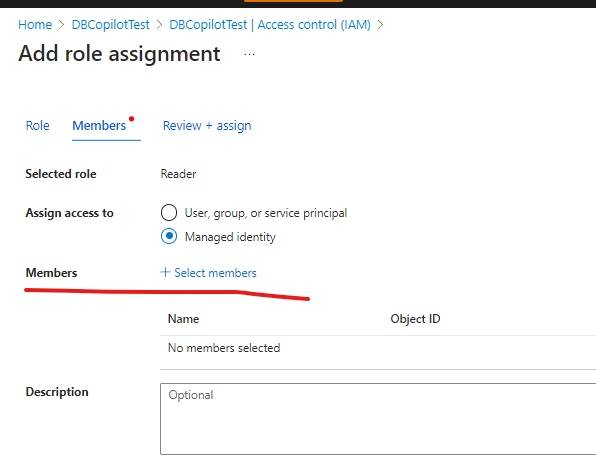

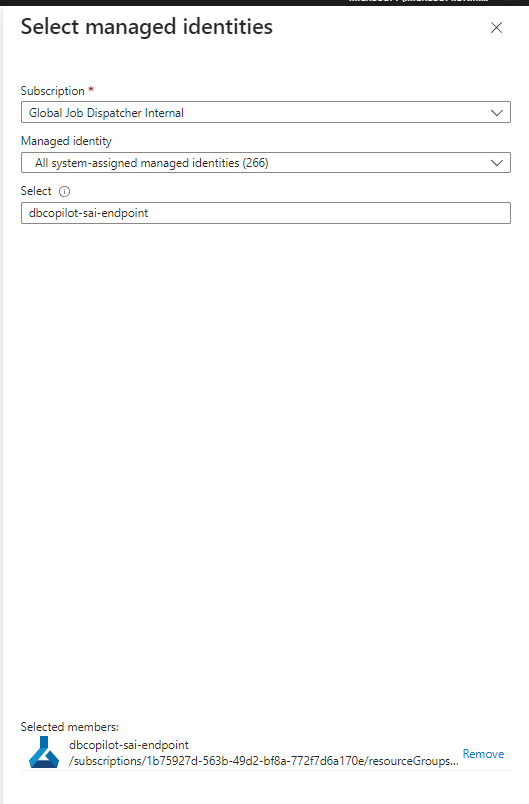

Sometimes, it takes a while for the authorization to take effect


### Deploy to your Endpoint

The Components are published to a [Registry](https://learn.microsoft.com/azure/machine-learning/how-to-manage-registries?view=azureml-api-2&tabs=cli), `azureml`, which should have access to by default, it can be accessed from any Workspace.
In the below cell we get the Component Definitions from the `azureml` registry.

In [ ]:
ml_registry = MLClient(credential=credential, registry_name="azureml")

db_copilot_component = ml_registry.components.get(
    "llm_ingest_dbcopilot_faiss_e2e", label="latest"
)

print(db_copilot_component)

In [ ]:
from azure.ai.ml.dsl import pipeline


@pipeline(
    name=f"test_db_copilot_e2e_pipeline_faiss_{db_copilot_component.version}",
    version=db_copilot_component.version,
)
def db_copilot_e2e_pipeline_faiss(
    aoai_connection: str,
    db_datastore: str,
    embeddings_model: str,
    chat_aoai_deployment_name: str,
    embedding_aoai_deployment_name: str,
    mir_environment: str,
    endpoint_name: str,
    deployment_name: str = "blue",
    selected_tables: str = None,
    max_sampling_rows: int = 3,
    tools: str = None,
):
    db_copilot_component(
        db_datastore=db_datastore,
        embeddings_model=embeddings_model,
        chat_aoai_deployment_name=chat_aoai_deployment_name,
        embedding_aoai_deployment_name=embedding_aoai_deployment_name,
        embedding_connection=aoai_connection,
        llm_connection=aoai_connection,
        endpoint_name=endpoint_name,
        deployment_name=deployment_name,
        mir_environment=mir_environment,
        selected_tables=selected_tables,
        max_sampling_rows=max_sampling_rows,
        tools=tools,
    )
    return {}

In [ ]:
deployment_name = "<Test-DBCopilot-Faiss>"  # You can write any name you want.
mir_environment = (
    "azureml://registries/azureml/environments/llm-dbcopilot-mir/versions/"
)
endpoint_name = "<my-test-endpoint>"
pipeline_job = db_copilot_e2e_pipeline_faiss(
    aoai_connection=aoai_connection_id,
    db_datastore=f"azureml://datastores/{datastore_name}",
    embeddings_model=f"azure_open_ai://deployment/{aoai_embedding_deployment_name}/model/{aoai_embedding_model_name}",
    chat_aoai_deployment_name=aoai_completion_deployment_name,
    embedding_aoai_deployment_name=aoai_embedding_deployment_name,
    mir_environment=mir_environment,
    endpoint_name=endpoint_name,
    deployment_name=deployment_name,
    selected_tables=None,
    max_sampling_rows=3,
    tools=None,
)

In [ ]:
running_pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="db_copilot_pipeline"
)
running_pipeline_job

In [ ]:
ml_client.jobs.stream(running_pipeline_job.name)

## Interacting with endpoint

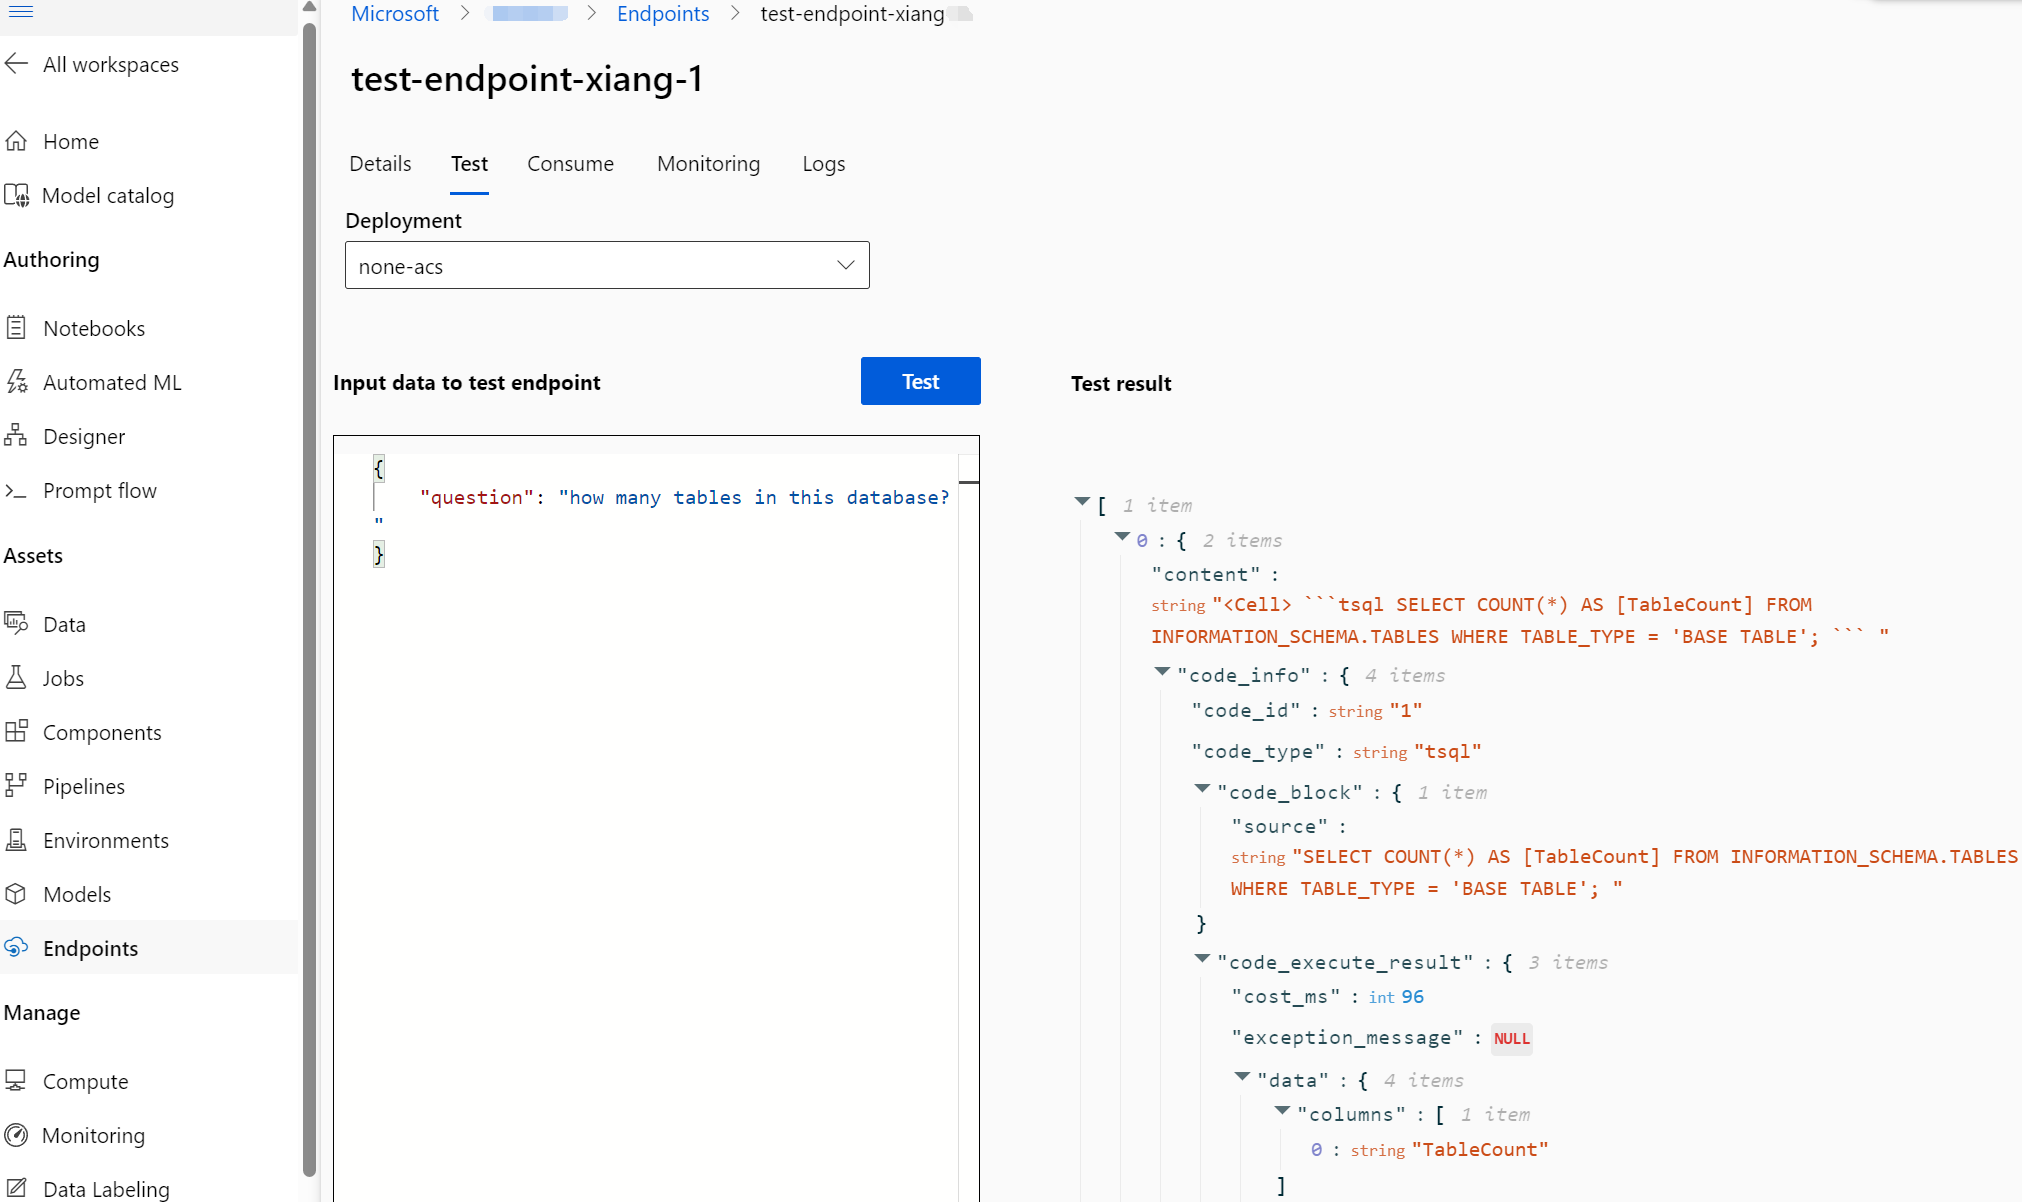

## Option2：Use DBCopilot with Promptflow
Prompt flow is a suite of development tools designed to streamline the end-to-end development cycle of LLM-based AI applications, from ideation, prototyping, testing, evaluation to production deployment and monitoring. It makes prompt engineering much easier and enables you to build LLM apps with production quality.


### Create custom environment
In Azure Machine Learning, an `environment` is a configuration object that defines the software dependencies required to run a machine learning model. It specifies the Python packages, environment variables, and other settings that are needed to run the model. Environments can be used to create Docker images, which can then be deployed as real-time endpoints or used to run batch scoring jobs. To learn more visit the [Microsoft Learn](https://learn.microsoft.com/en-us/azure/machine-learning/concept-environments?view=azureml-api-2) website for detailed documentation on how to use Azure ML environments.



1. Open Azure ML Studio: Go to the [Azure Machine Learning studio](https://ml.azure.com) and sign in with your credentials.

2. Navigate to Environments: On the left-hand side menu, click on "Environments". This will take you to the environments section where you can see existing environments and create new ones.
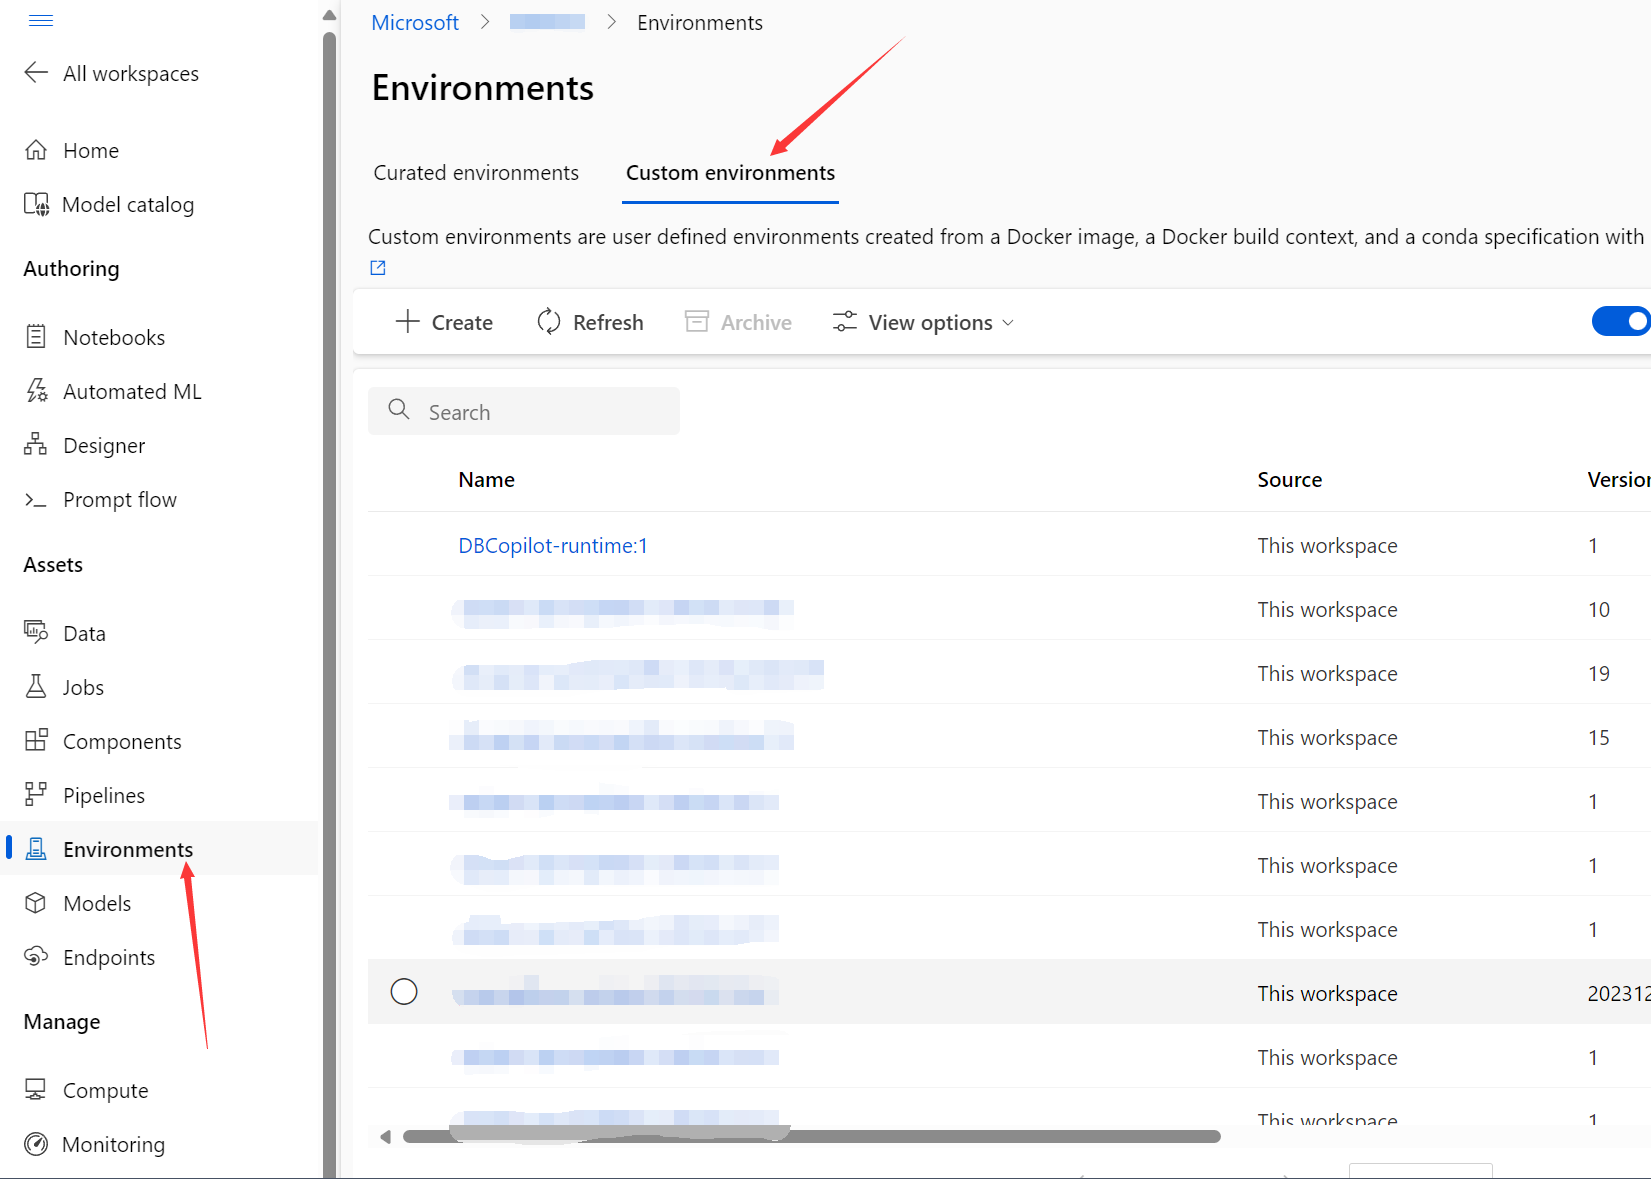

3. Create New Environment: Click on the "Create" to start the process of creating a new environment.

4. Specify Environment Configuration:</br>
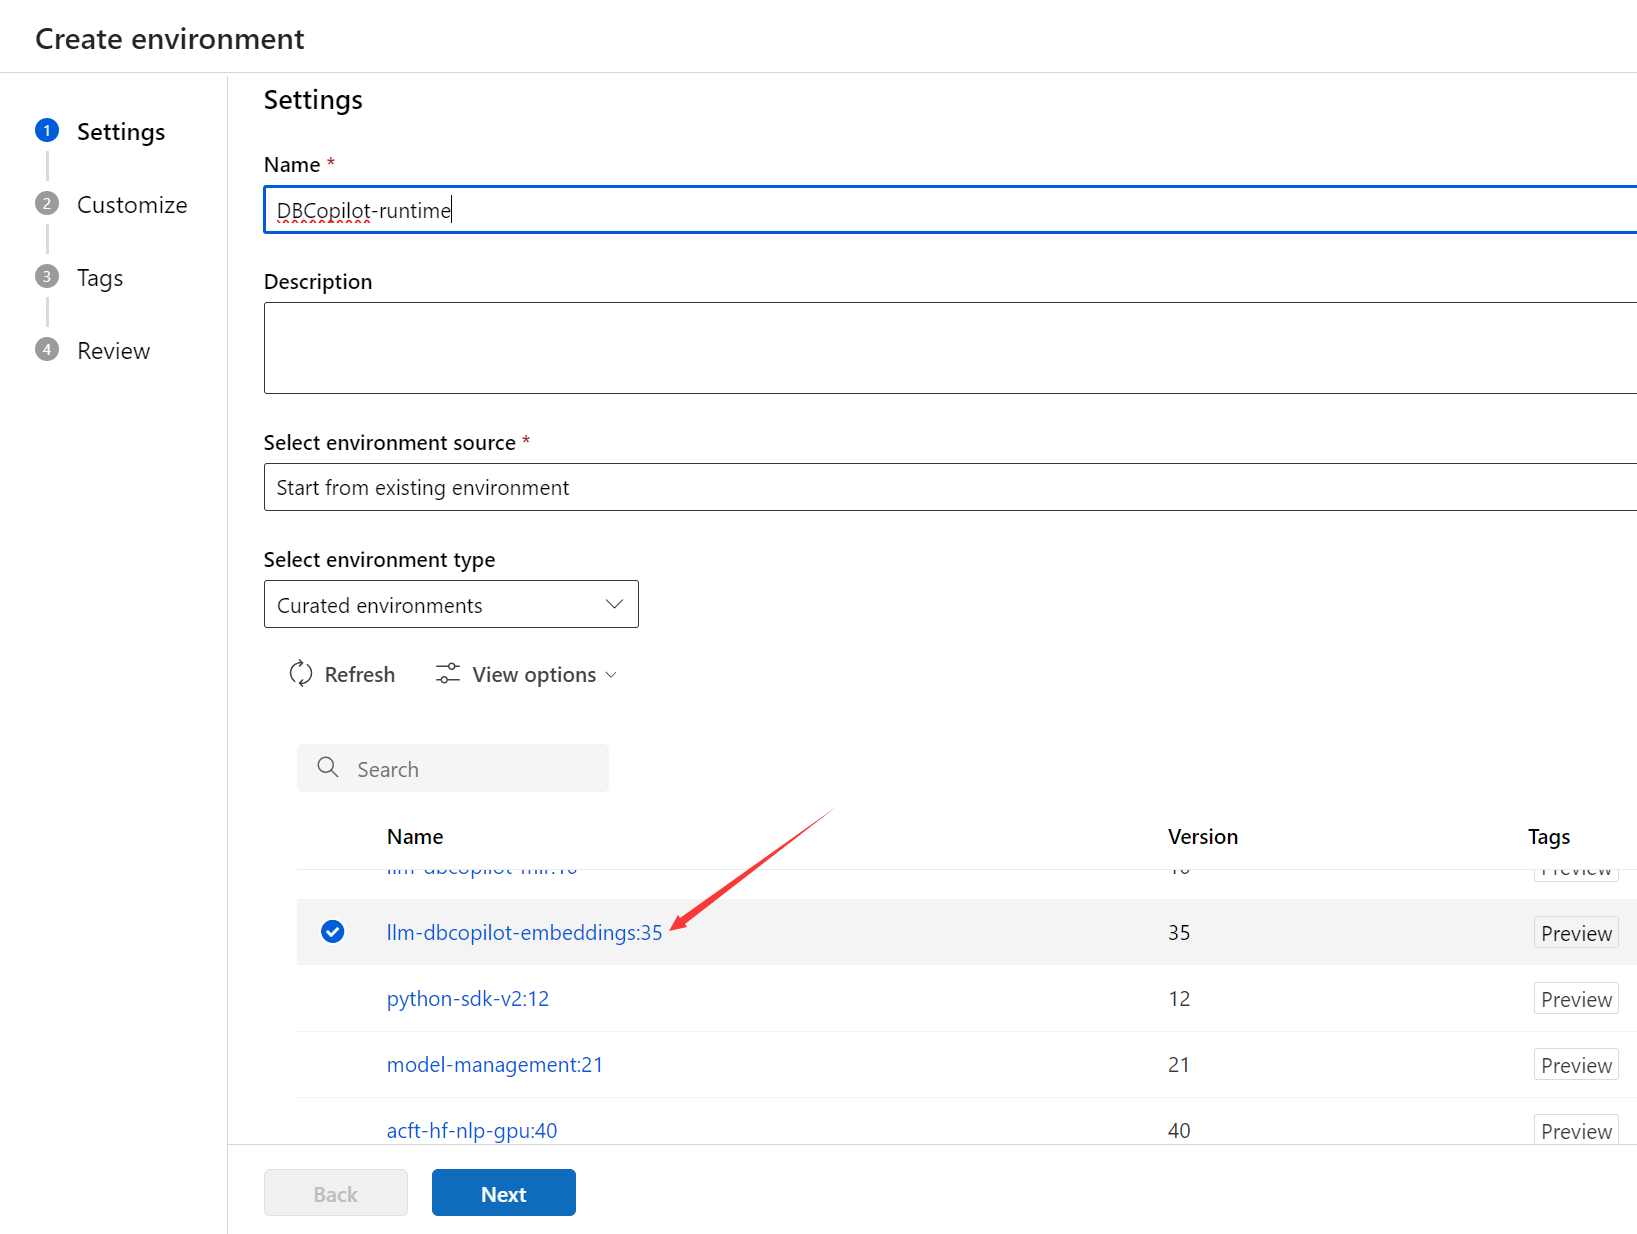
- **Name**: Enter a name for your environment.
- **Description (optional)**: Provide a description for your environment.
- **Select Environment Sources**: Choose the source of your environment. You can select from a list of pre-built environments, a Dockerfile, or a Conda environment file.
- **Environment Type**: Choose "Curated environments" for a pre-configured environment or "Custom environments" if you want to specify a custom environment.

5. Register the Environment: After the environment is created, it will be automatically registered with your Azure ML Workspace and can be used for training runs, hyperparameter tuning, or model deployment.



### Create a runtime on UI
A prompt flow runtime provides computing resources that are required for the application to run, including a Docker image that contains all necessary dependency packages. This reliable and scalable runtime environment enables prompt flow to efficiently execute its tasks and functions for a seamless user experience. To learn more visit the [Microsoft Learn](https://learn.microsoft.com/en-us/azure/machine-learning/prompt-flow/how-to-create-manage-runtime?view=azureml-api-2&tabs=cli#use-a-runtime-to-submit-a-flow-run-in-clisdk) website for detailed documentation on how to create and manage prompt flow runtimes.

#### Create a compute instance
An Azure Machine Learning compute instance is a managed cloud-based workstation for data scientists. Each compute instance has only one owner, although you can share files between multiple compute instances. To learn more visit the [Microsoft Learn](https://learn.microsoft.com/en-us/azure/machine-learning/concept-compute-instance?view=azureml-api-2) website for detailed documentation on what is an Azure Machine Learning compute instance.
1. Navigate to [Azure Machine Learning studio](https://ml.azure.com).

2. Under Manage, select Compute.

3. Select Compute instance at the top.

4. If you have no compute instances, select Create in the middle of the page.</br>
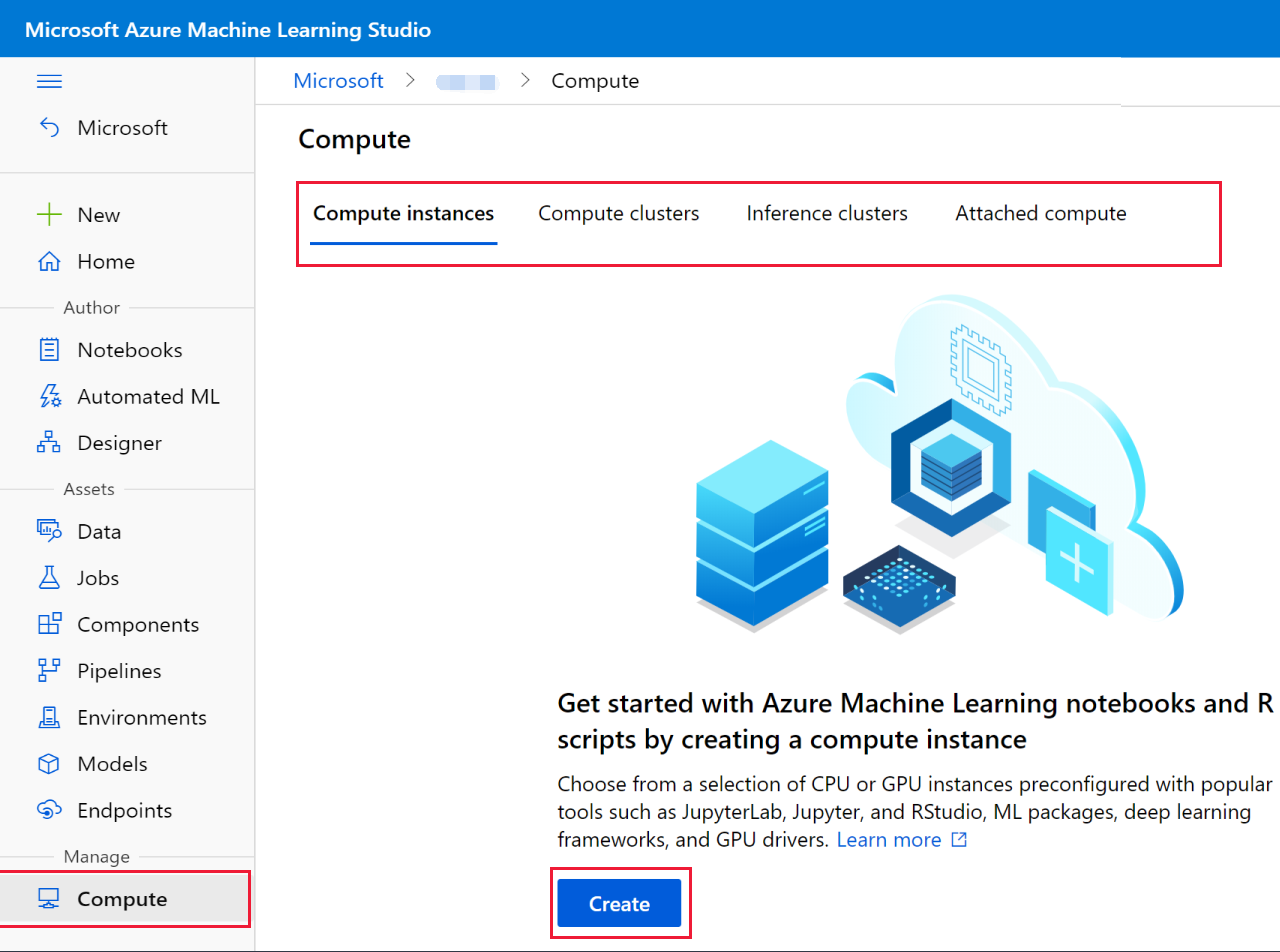
5. If you see a list of compute resources, select +New above the list.</br>
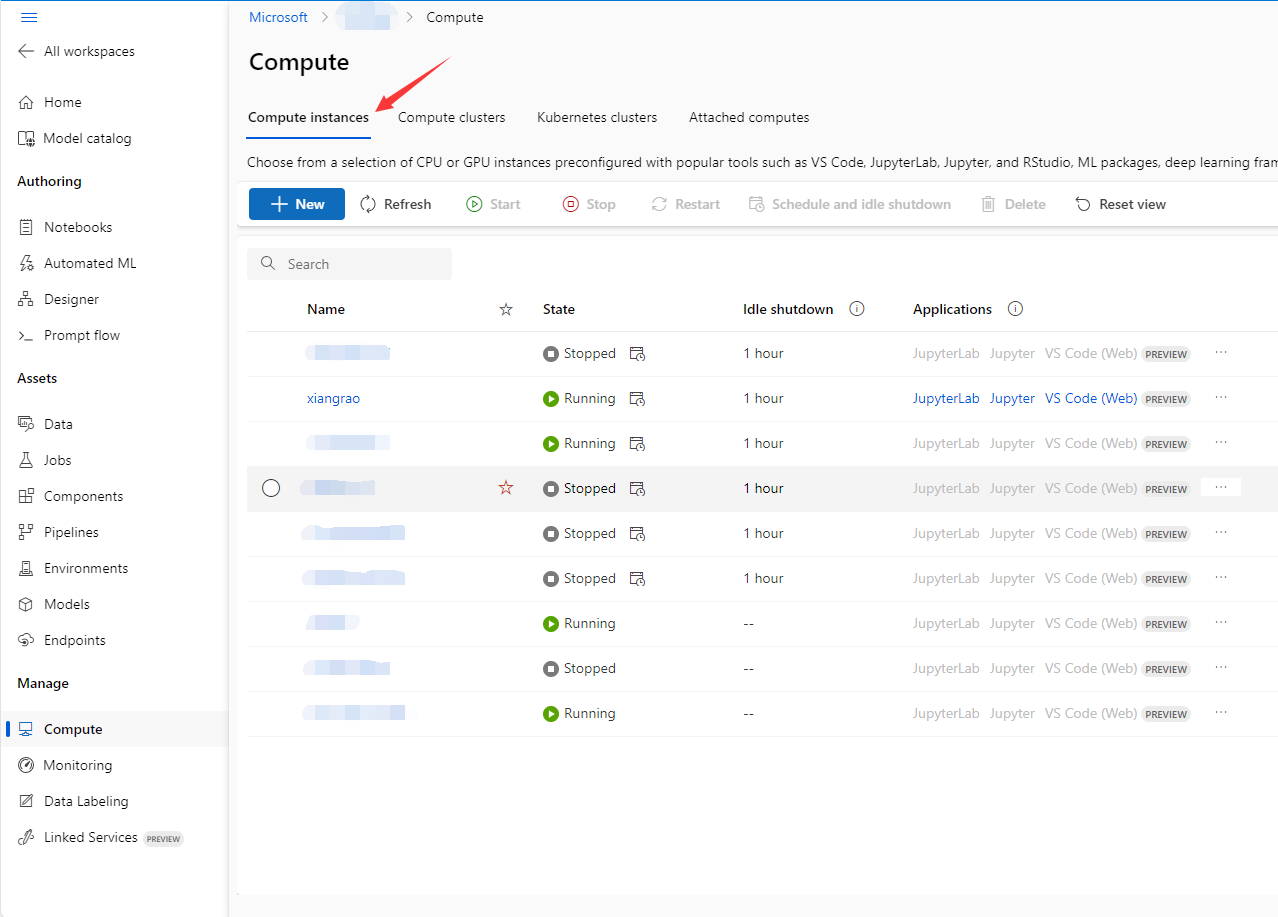
6. Fill in the form to create a new compute instance.</br>
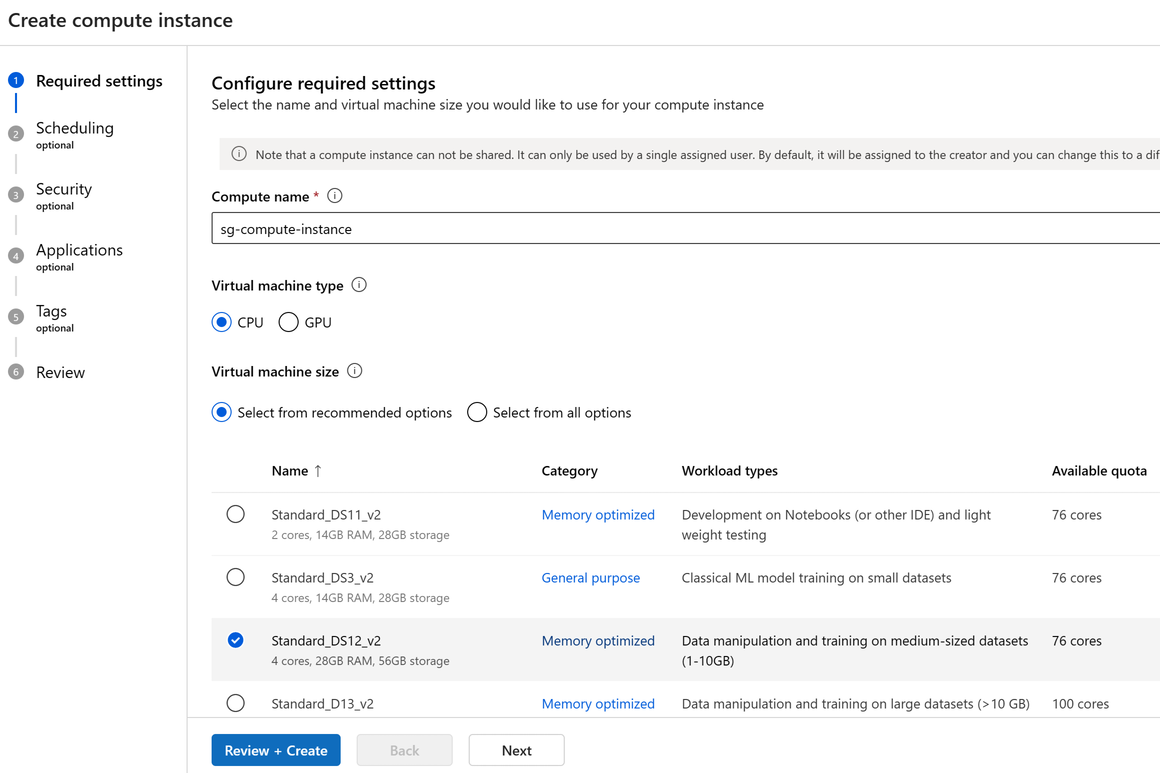 </br>
7 .Select Review + Create to create the compute instance.


#### Create a compute instance runtime on a runtime page
Before you create a compute instance runtime, make sure that a compute instance is available and running.

1. On the page that lists runtimes, select "Create".</br>
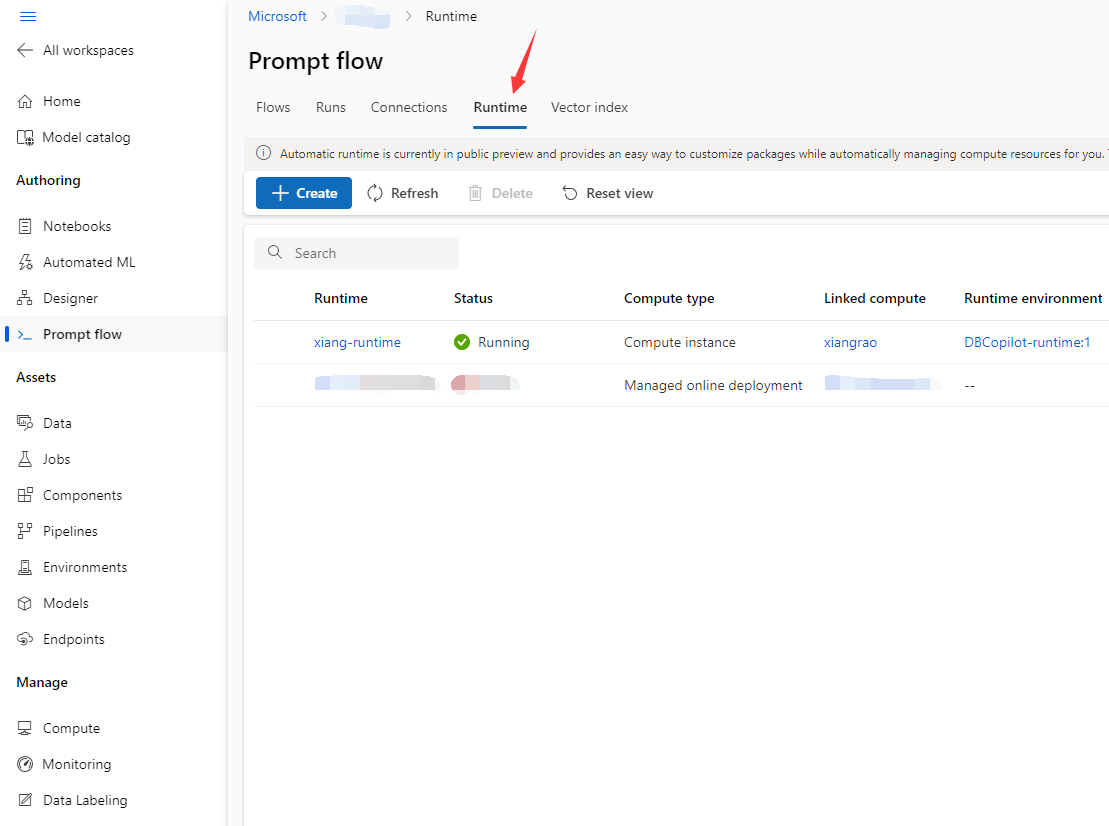
2. Select the compute instance that you want to use as a runtime.</br>
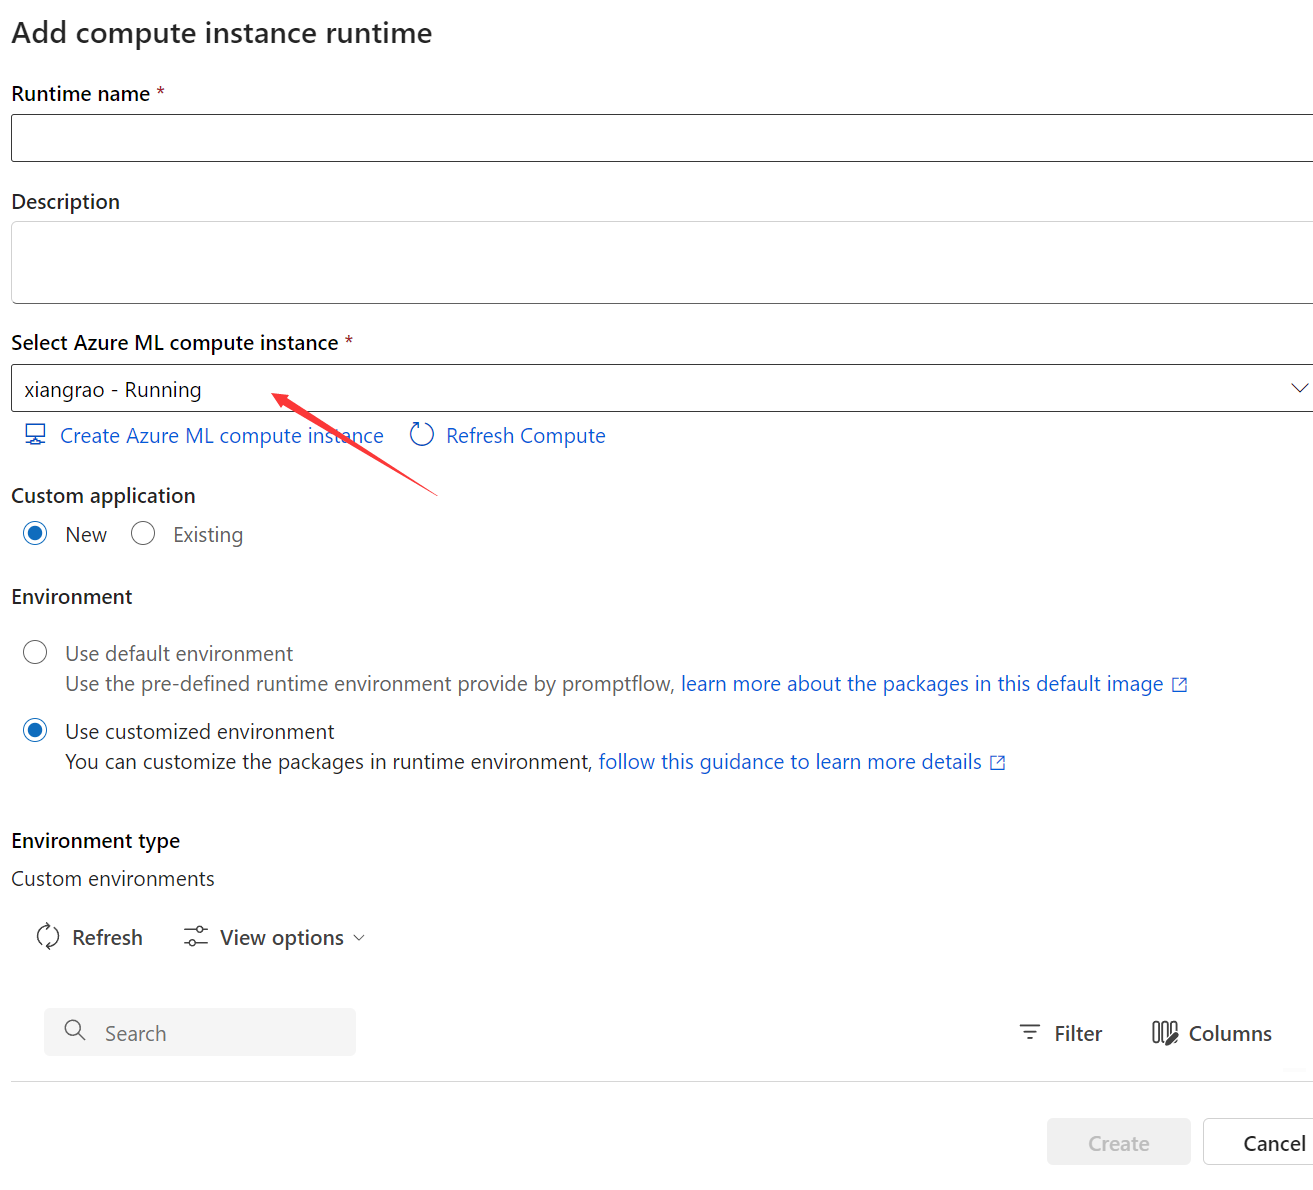
3. Select the Authenticate button to authenticate on the compute instance. You need to authenticate only one time per region in six months.</br>
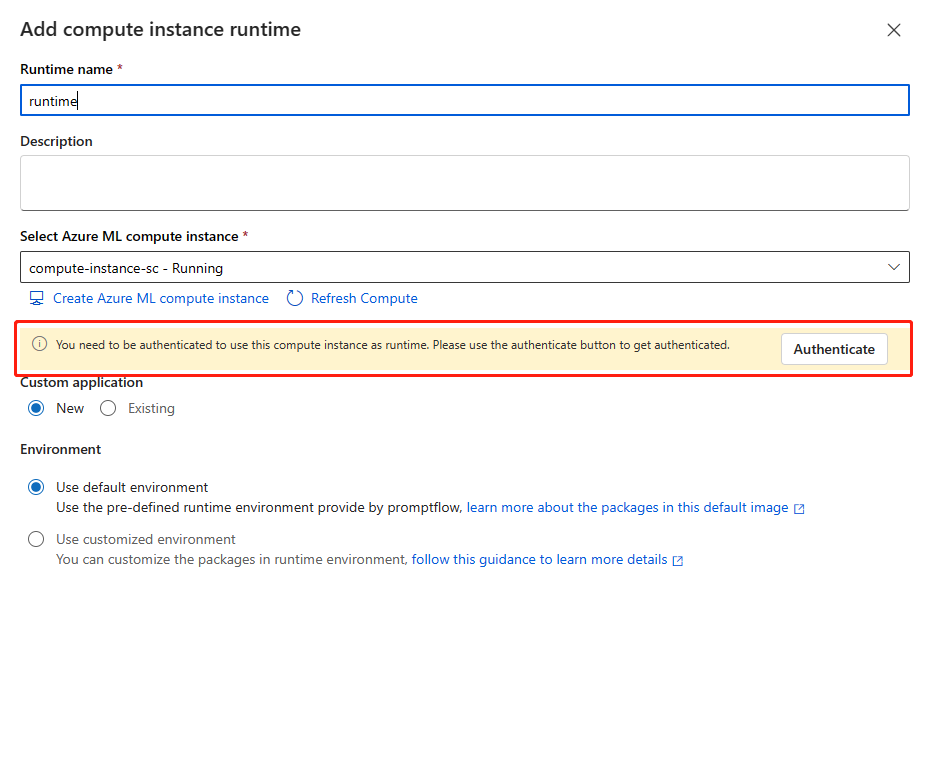
4. Decide whether to create a custom application or select an existing one as a runtime:</br>
    Select use customized environment, and then choose an environment from the list that you created.</br>
    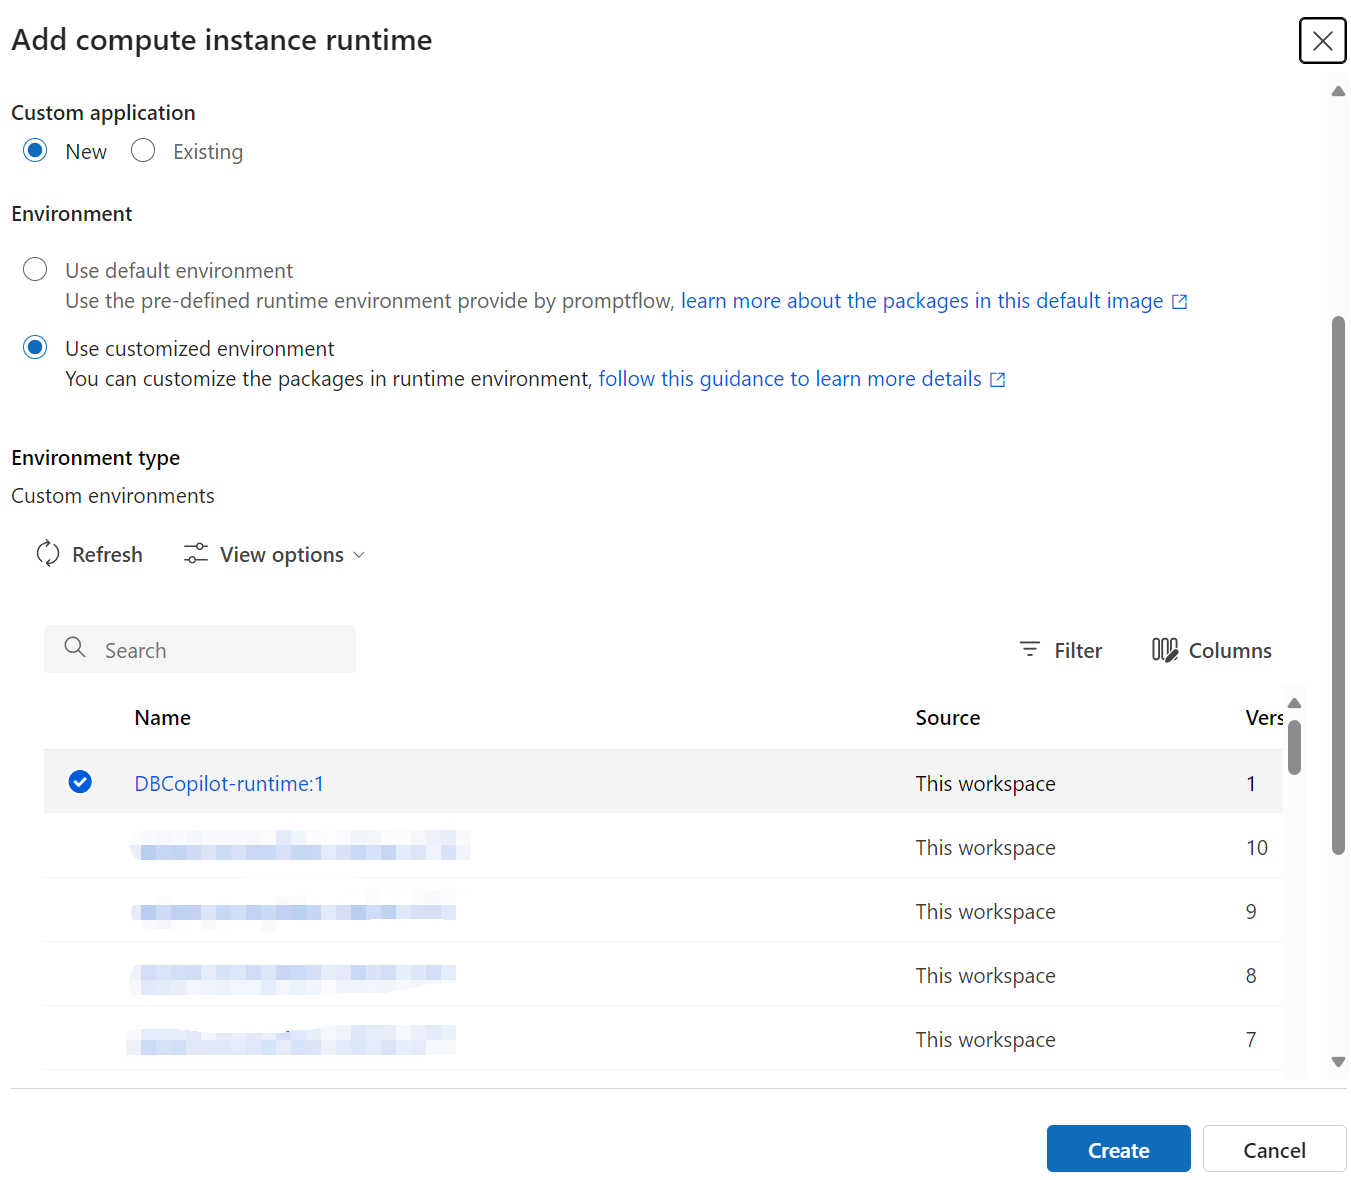


### Setup Pipeline

The Components are published to a [Registry](https://learn.microsoft.com/azure/machine-learning/how-to-manage-registries?view=azureml-api-2&tabs=cli), `azureml`, which should have access to by default, it can be accessed from any Workspace.
In the below cell we get the Component Definitions from the `azureml` registry.
After the pipeline complete, it will create a promptflow which could be used to chat with the db.

In [ ]:
ml_registry = MLClient(credential=credential, registry_name="azureml")

db_copilot_component = ml_registry.components.get(
    "llm_ingest_db_to_faiss", label="latest"
)

print(db_copilot_component)

In [ ]:
from azure.ai.ml.dsl import pipeline


@pipeline(name=f"db_copilot_vector_pipeline_faiss", default_compute="serverless")
def db_copilot_vector_pipeline_faiss(
    aoai_connection: str,
    db_datastore: str,
    embeddings_model: str,
    chat_aoai_deployment_name: str,
    embedding_aoai_deployment_name: str,
    mlindex_dataset_name: str,
    selected_tables: str = None,
    max_sampling_rows: int = 3,
    runtime: str = None,
):
    db_copilot_component(
        db_datastore=db_datastore,
        embeddings_model=embeddings_model,
        chat_aoai_deployment_name=chat_aoai_deployment_name,
        embedding_aoai_deployment_name=embedding_aoai_deployment_name,
        embeddings_dataset_name=mlindex_dataset_name,
        embedding_connection=aoai_connection,
        llm_connection=aoai_connection,
        selected_tables=selected_tables,
        max_sampling_rows=max_sampling_rows,
        runtime=runtime,
    )
    return {}

In [ ]:
asset_name = "llm_index_db_dataset"
runtime = "<your-runtime-name>"
pipeline_job = db_copilot_vector_pipeline_faiss(
    aoai_connection=aoai_connection_id,
    db_datastore=f"azureml://datastores/{datastore_name}",
    embeddings_model=f"azure_open_ai://deployment/{aoai_embedding_deployment_name}/model/{aoai_completion_model_name}",
    chat_aoai_deployment_name=aoai_completion_deployment_name,
    embedding_aoai_deployment_name=aoai_embedding_deployment_name,
    mlindex_dataset_name=asset_name,
    selected_tables='["[dbo].[jobs]"]',
    max_sampling_rows=3,
    runtime=runtime,
)

In [ ]:
# These are added so that in progress index generations can be listed in UI, this tagging is done automatically by UI.
pipeline_job.properties["azureml.mlIndexAssetName"] = asset_name
pipeline_job.properties["azureml.mlIndexAssetKind"] = "faiss"
pipeline_job.properties["azureml.mlIndexAssetSource"] = "Database"

In [ ]:
running_pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="db_copilot_pipeline"
)
running_pipeline_job

In [ ]:
ml_client.jobs.stream(running_pipeline_job.name)

## Interacting with promptflow
Once the pipeline has run successfully, you can see your flow in the promptflow runs</br>
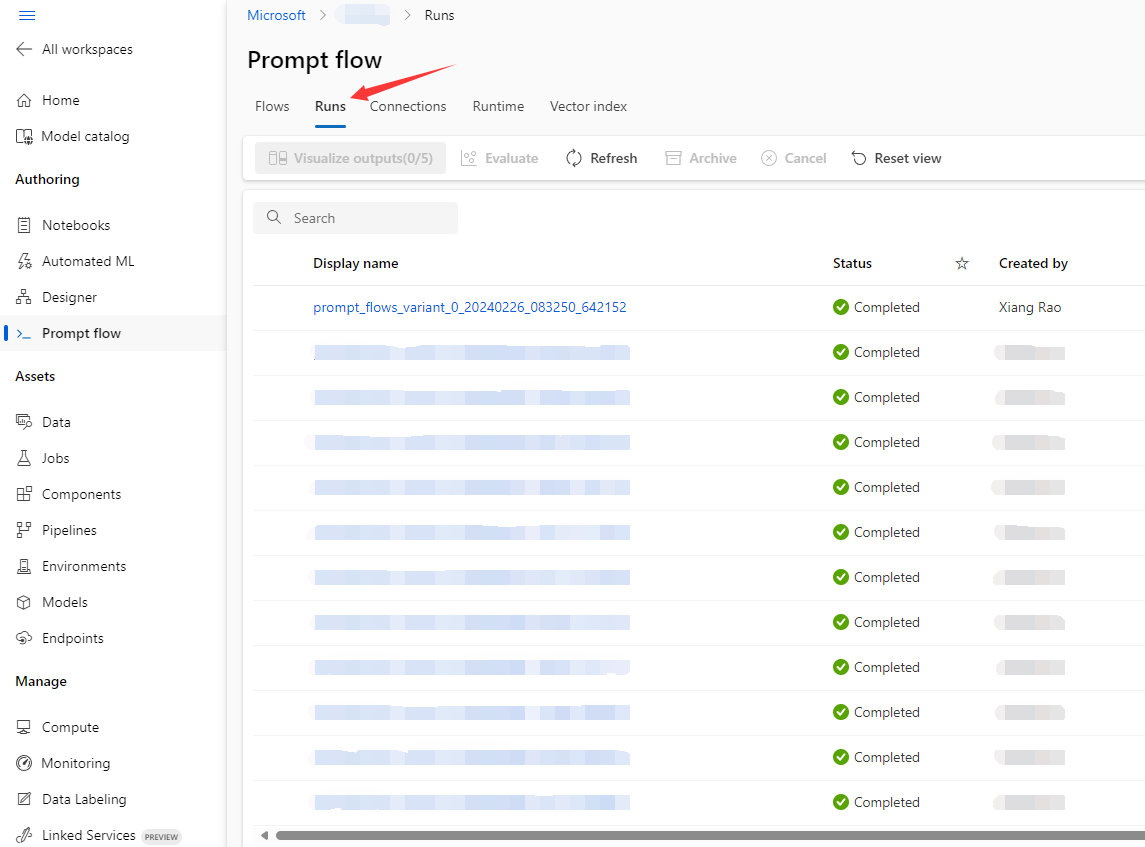</br>

Click the clone button and select the flow type as chat flow, then you can see the successfully cloned flow in the Flows
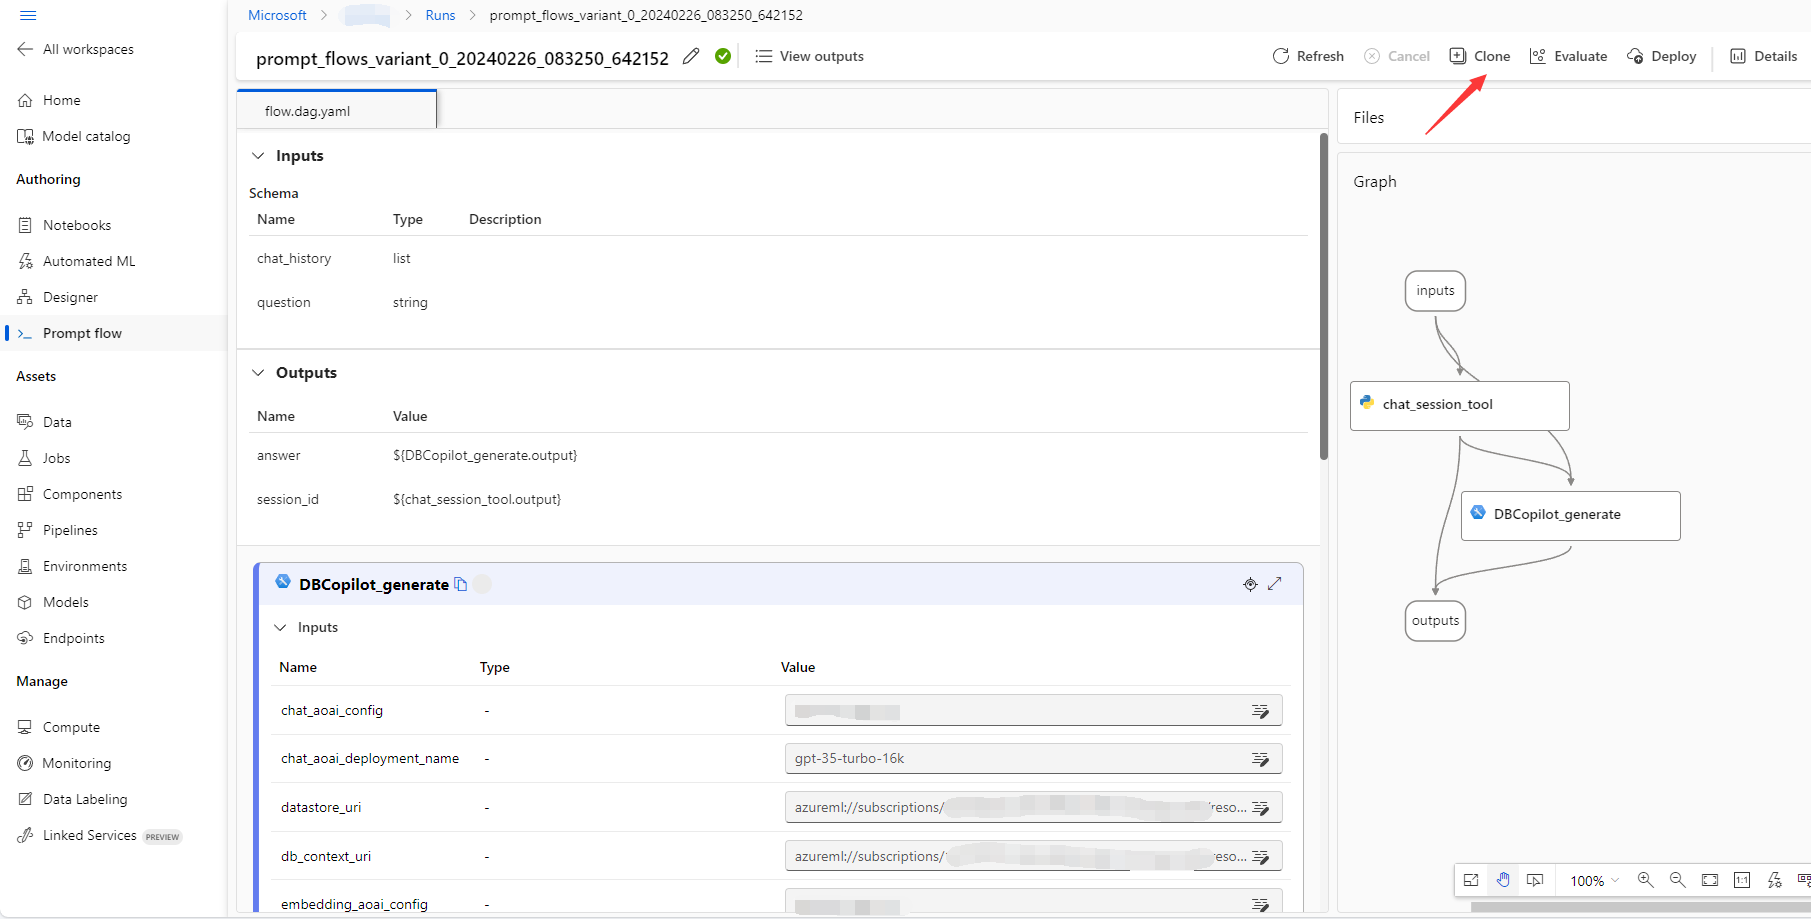
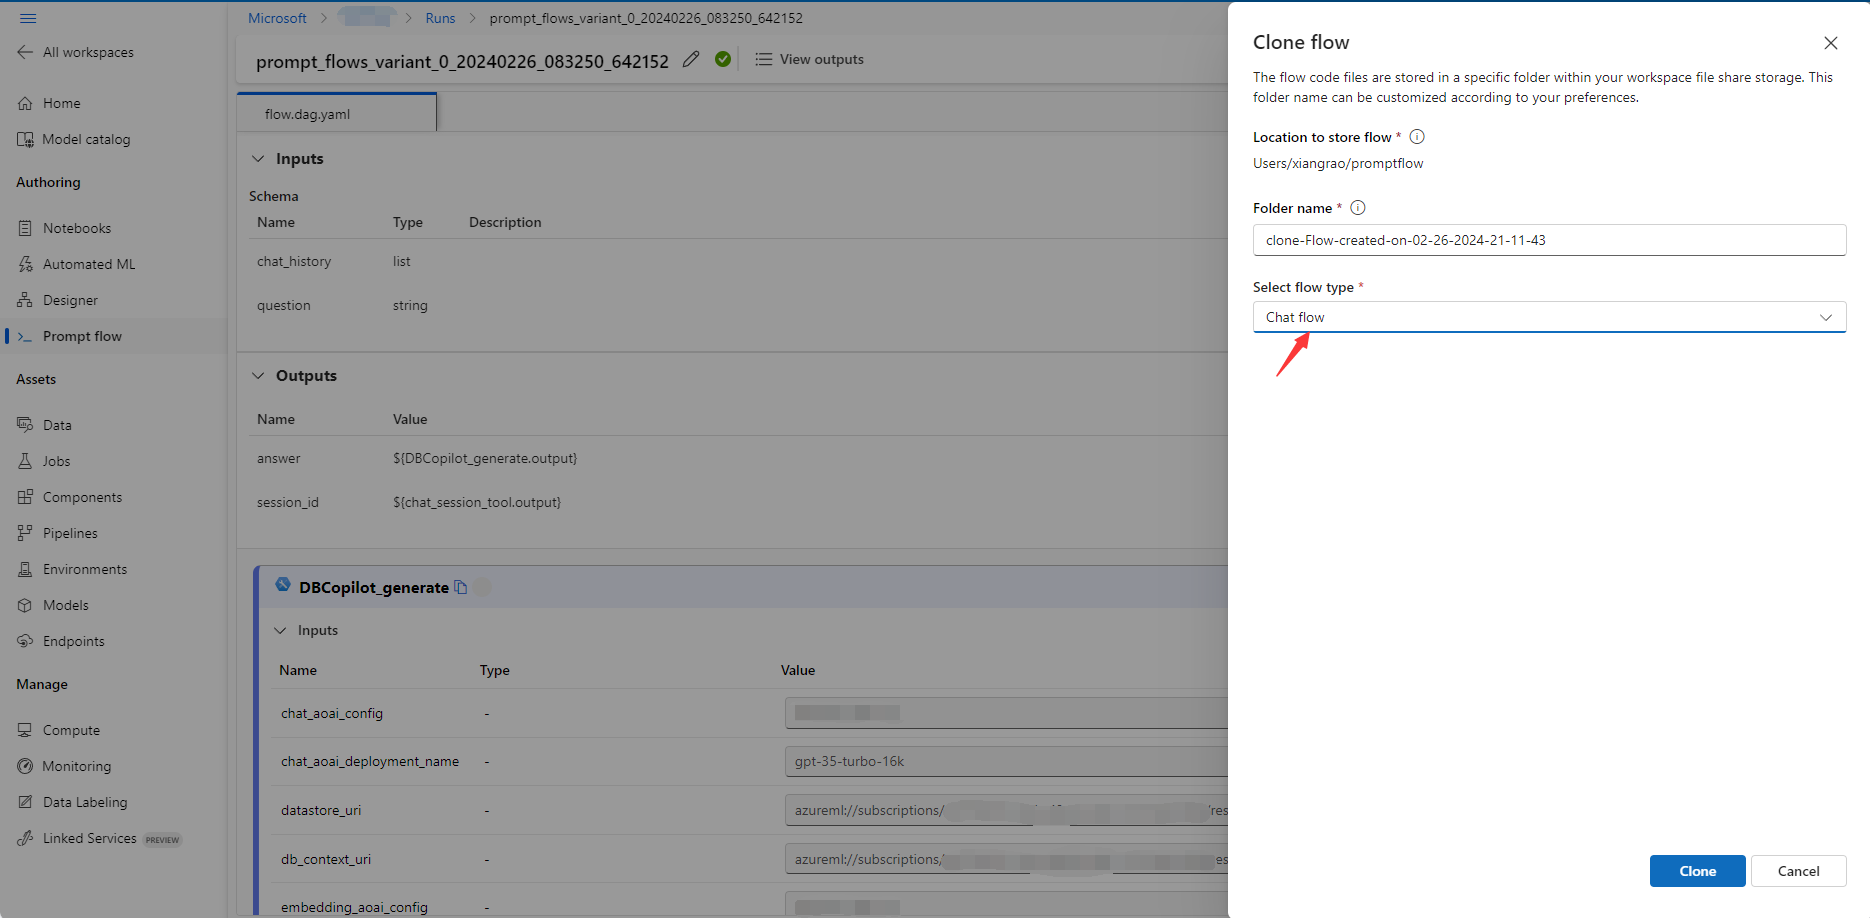

When you're authoring a flow, you can select and change the runtime from the Runtime dropdown list on the upper right of the flow page.
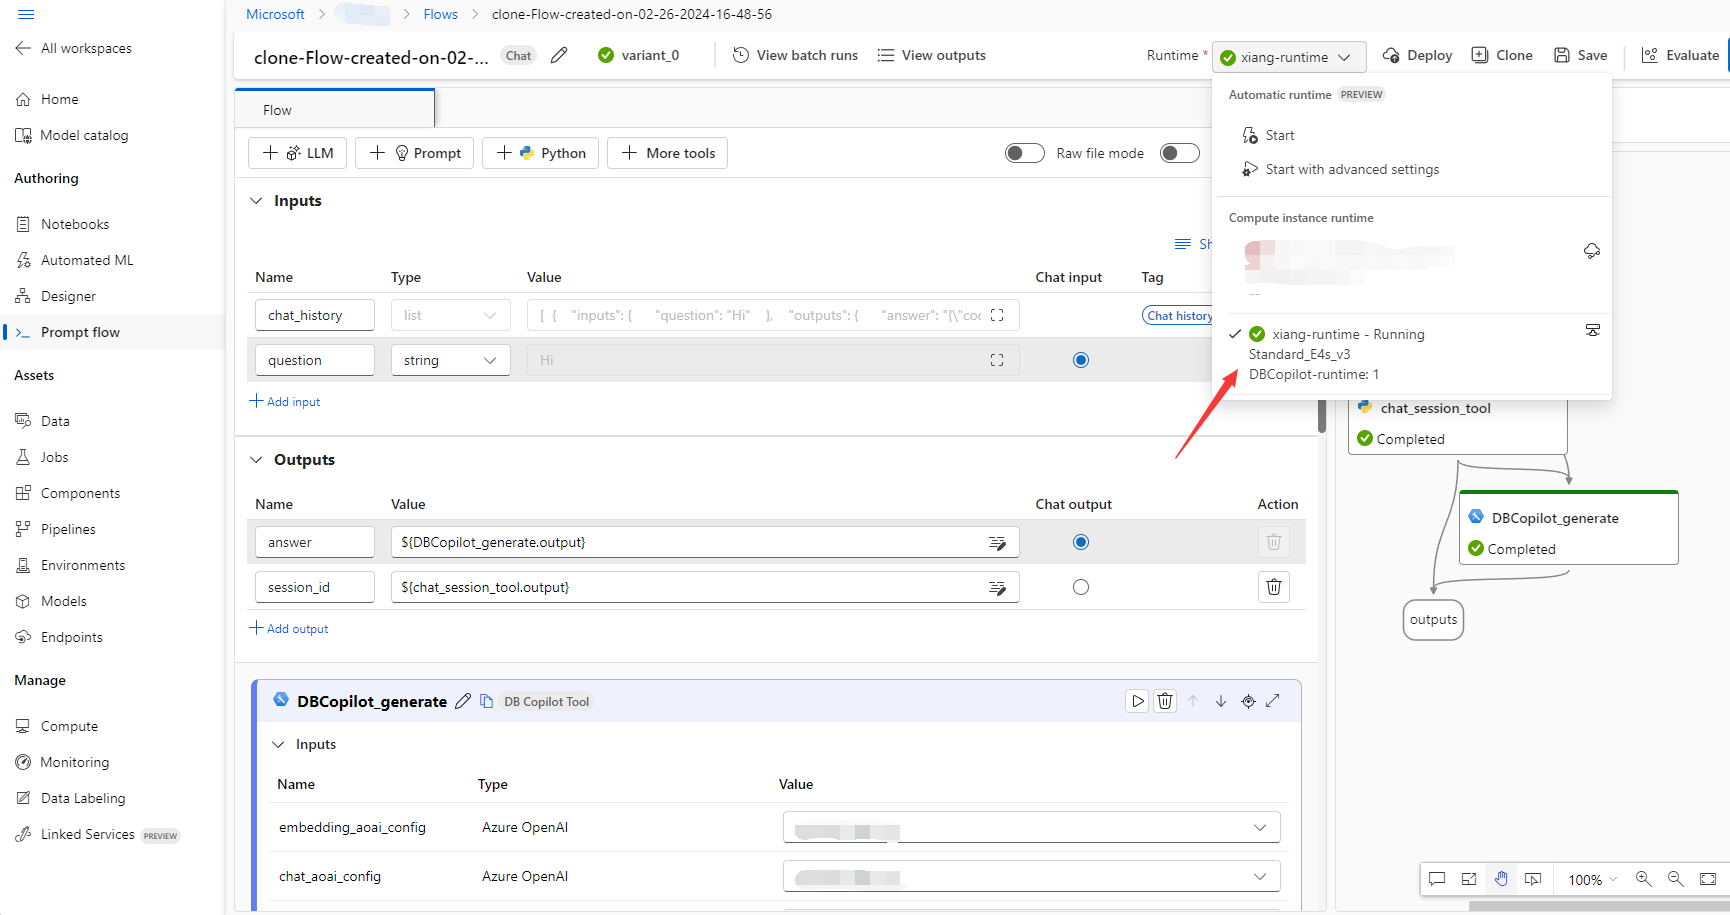
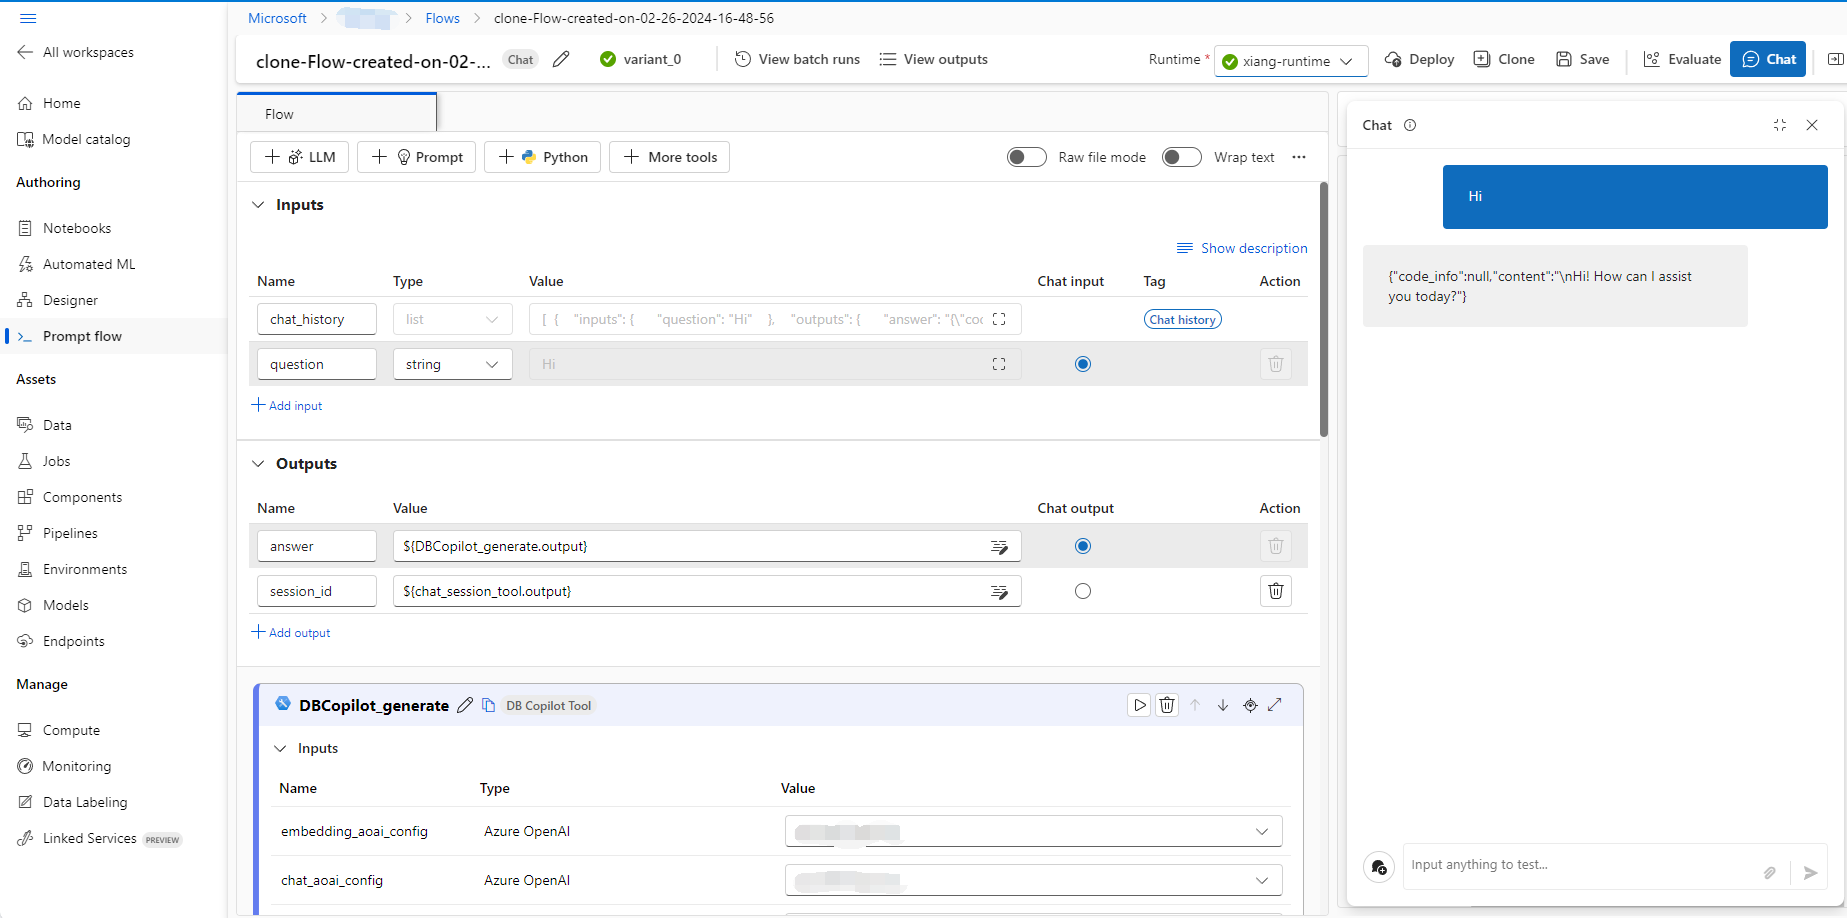